# Setup

In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from collections import defaultdict
import datetime
from ipysigma import Sigma
import networkx as nx
from scipy.stats import spearmanr
from scipy.stats import wilcoxon
import scipy.stats as stats
import scikit_posthocs as sp

# Figure 2 (Left) -- Average Superchat Income vs. Gini Index of Superchat Income across Months 

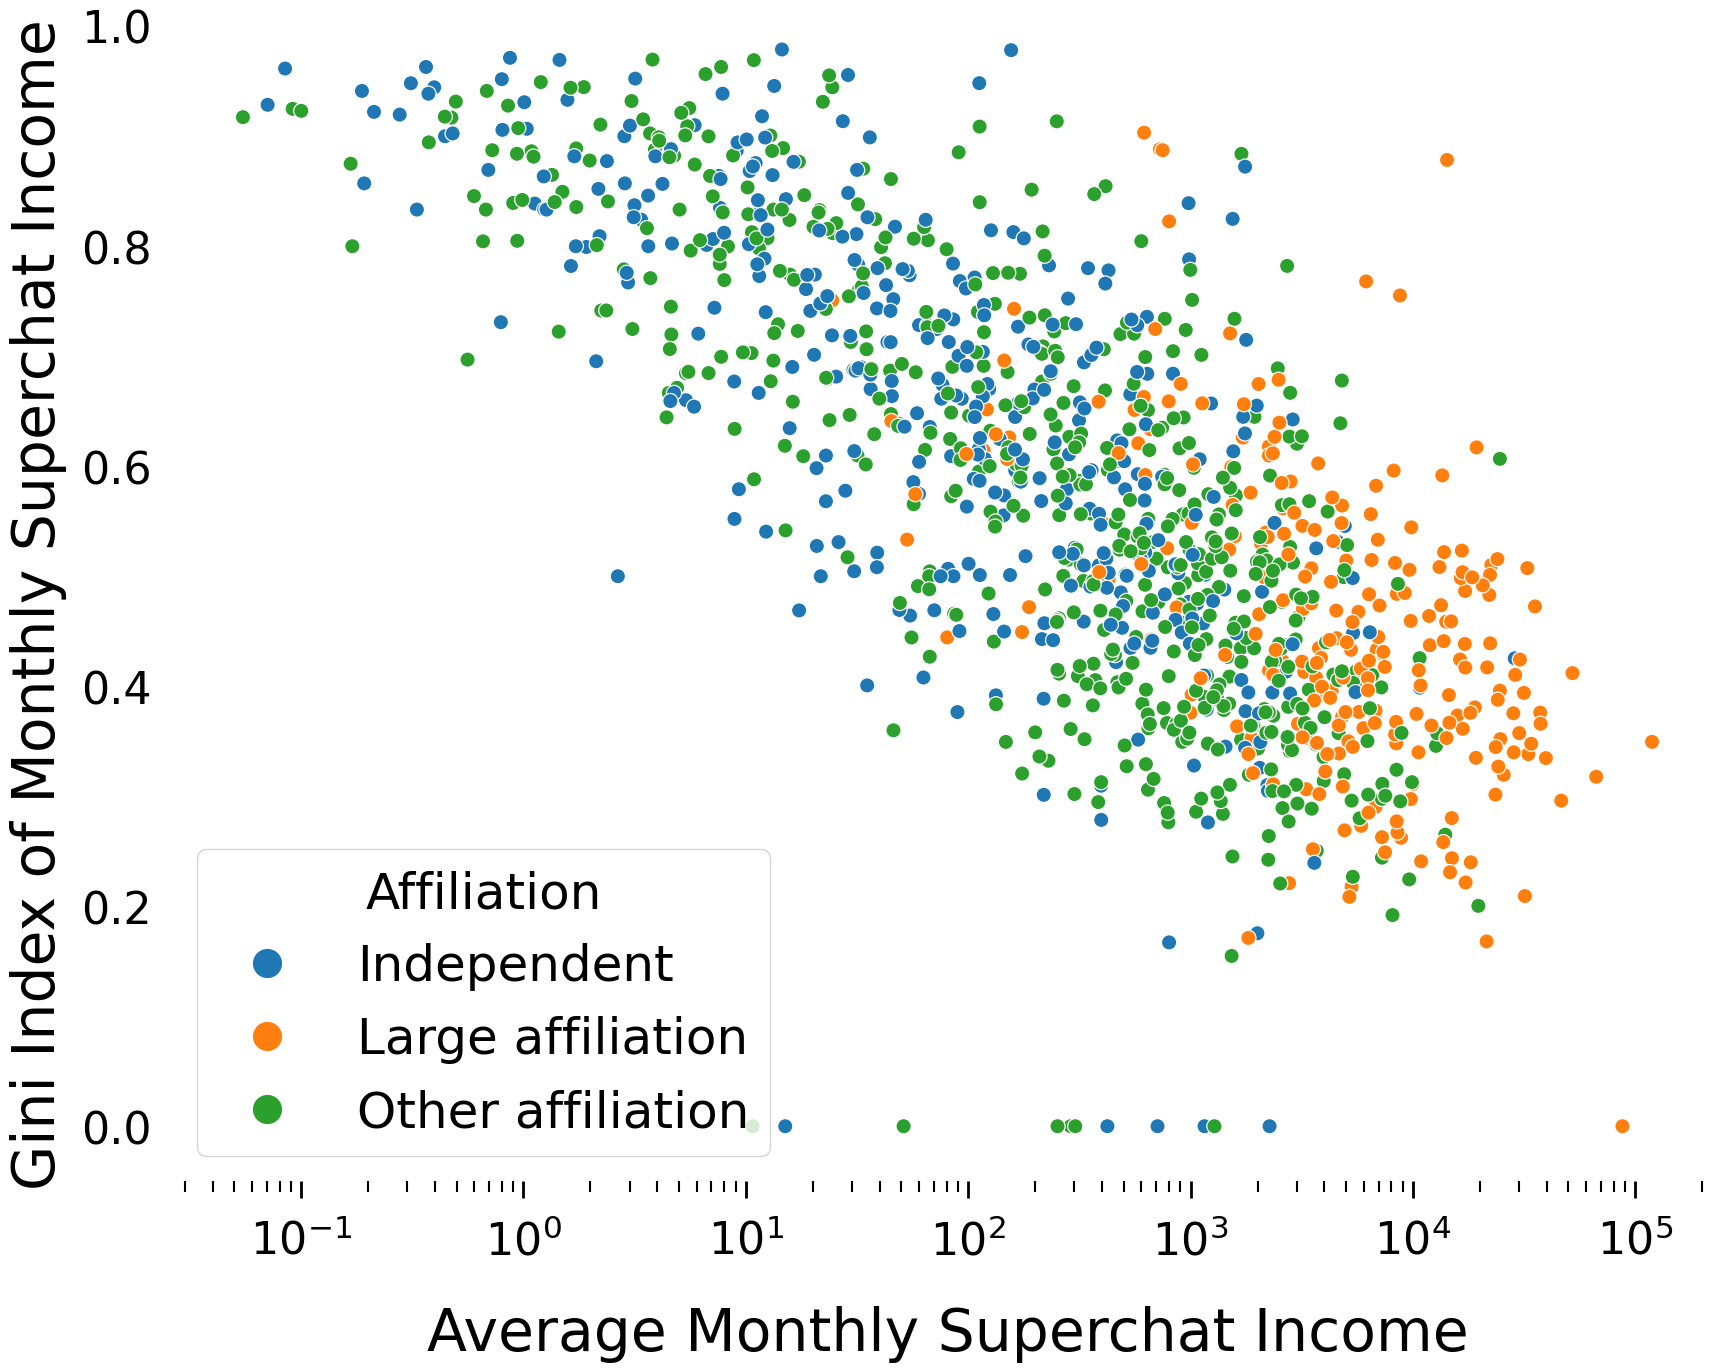

Spearman correlation: 0.30127697588512964, p-value: 2.818859324620285e-37


In [2]:
### data import
vtuber_stats = pd.read_csv('data/vtuber_stats.tsv', sep='\t')
vtuber_gini_income_df = vtuber_stats[vtuber_stats['gini_index_by_session_month'].notna()]
x = vtuber_gini_income_df['avg_income_per_session_month']
y = vtuber_gini_income_df['gini_index_by_session_month']

### create plot
plt.figure(figsize=(20, 15))
hue_order = ['Independent', 'Large affiliation', 'Other affiliation']
sns.scatterplot(data=vtuber_gini_income_df, x='avg_income_per_session_month', y='gini_index_by_session_month', hue='affiliation_type', hue_order=hue_order, color=sns.color_palette("Set1")[1], alpha=1, s=120)
plt.xlabel('Average Monthly Superchat Income', fontsize=42, labelpad=30)
plt.ylabel('Gini Index of Monthly Superchat Income', fontsize=42, labelpad=10)
plt.xscale('log')
plt.yscale('linear')
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.gca().xaxis.set_tick_params(pad=15, width=2, length=12)
plt.gca().xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs='auto', numticks=10))
plt.gca().xaxis.set_tick_params(which='minor', length=8, width=1.5, color='black')
plt.gca().yaxis.set_tick_params(pad=15, length=0)
plt.ylim(-0.05, 1)
plt.legend(title="Affiliation", title_fontsize=36, fontsize=36, markerscale=2.0)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.show()

### statistical test
df_cleaned = vtuber_stats[['avg_income_per_session_month', 'gini_index_by_session_month']].dropna()
corr, p_value = spearmanr(df_cleaned['avg_income_per_session_month'], df_cleaned['gini_index_by_session_month'])
print(f"Spearman correlation: {corr}, p-value: {p_value}")

# Figure 5 -- Temporal Occurrences of Superchats across the Whole Session

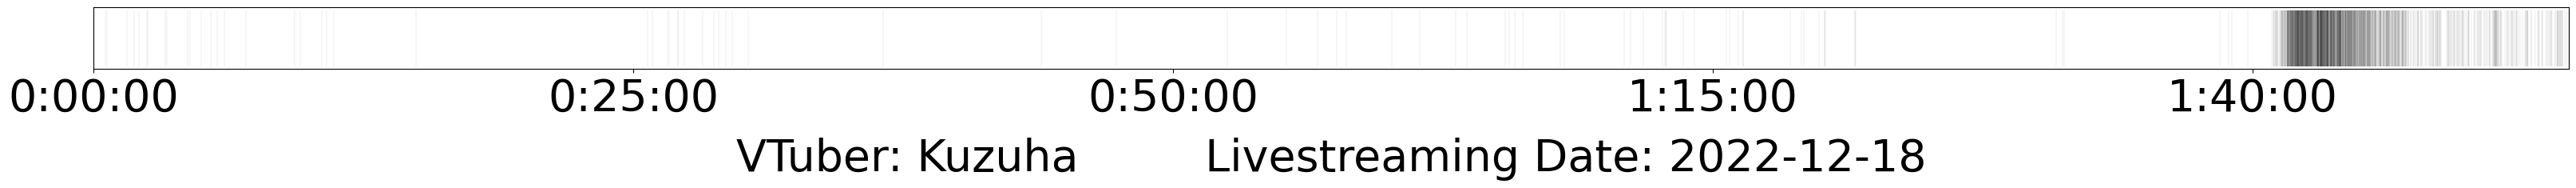

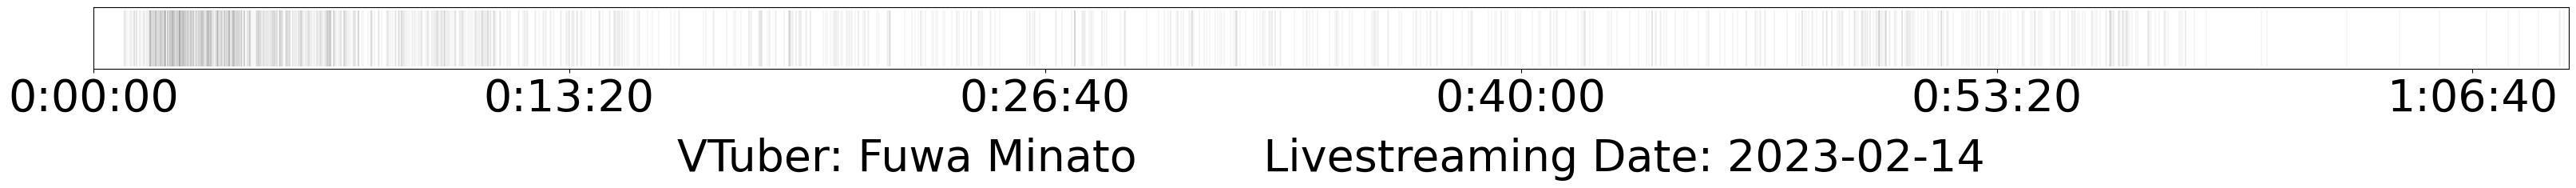

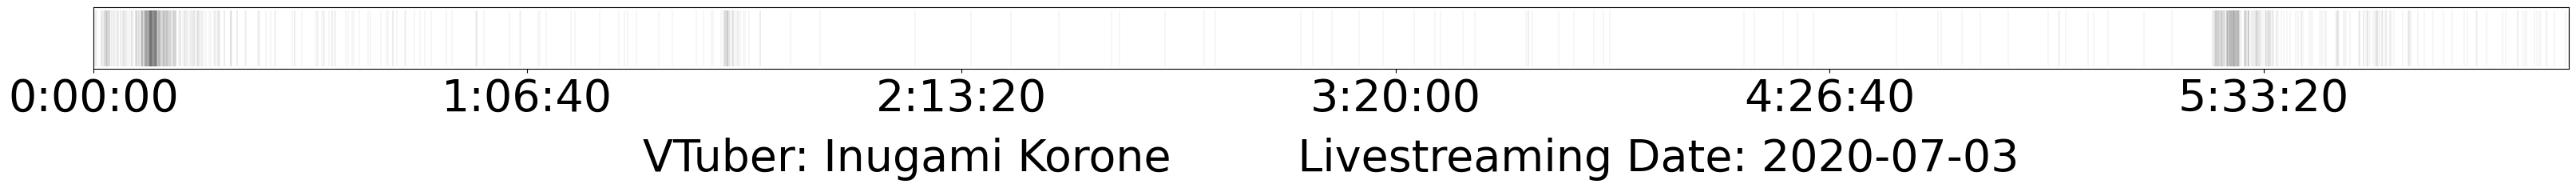

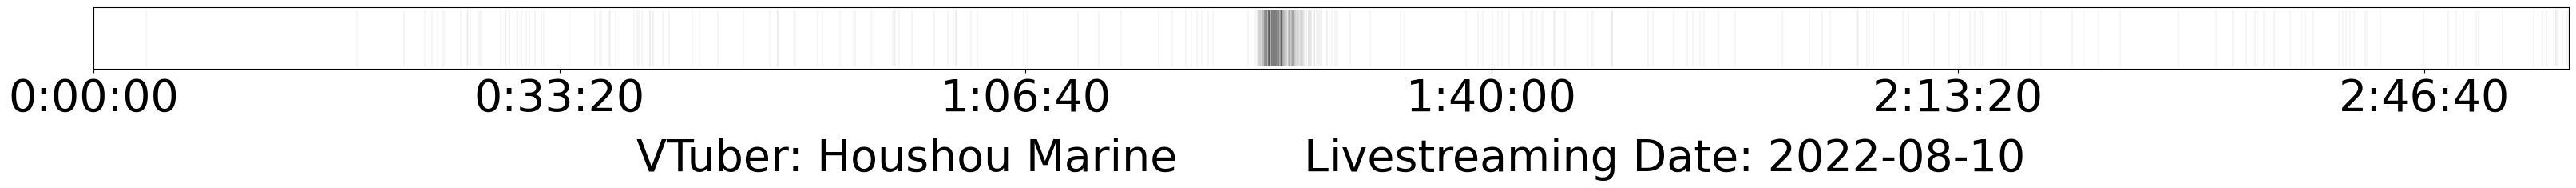

In [3]:
### Convert timestamp to datetime
def convert_usec_to_datetime(usec):
    timestamp_sec = usec / 1_000_000
    dt = datetime.datetime.fromtimestamp(timestamp_sec, datetime.timezone.utc)
    return dt

### data import
with open('data/payment_timestamps_of_sampled_vtubers.jsonl', 'r') as f:
    for line in f:
        data = json.loads(line)
        timestamps = data['payment_timestamps']
        converted_stamps = [convert_usec_to_datetime(usec) for usec in timestamps]
        reference_time = converted_stamps[0]
        relative_times = [(stamp - reference_time).total_seconds() for stamp in converted_stamps]

        ### Create plots
        fig, ax = plt.subplots(figsize=(40, 1))
        ax.vlines(relative_times, 0, 1, colors='k', linewidth=0.05)
        ax.set_xlim(min(relative_times), max(relative_times))
        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: str(datetime.timedelta(seconds=int(x)))))
        ax.yaxis.set_visible(False)
        plt.xticks(fontsize=40, rotation=0)
        plt.xlabel(f'VTuber: {' '.join(data["vtuber"].split('_'))}         Livestreaming Date: {reference_time.strftime('%Y-%m-%d')}', fontsize=40, labelpad=15)
        plt.show()

# Figure 6(a) -- Average Rates of Loyal Viewers across VTubers by Month

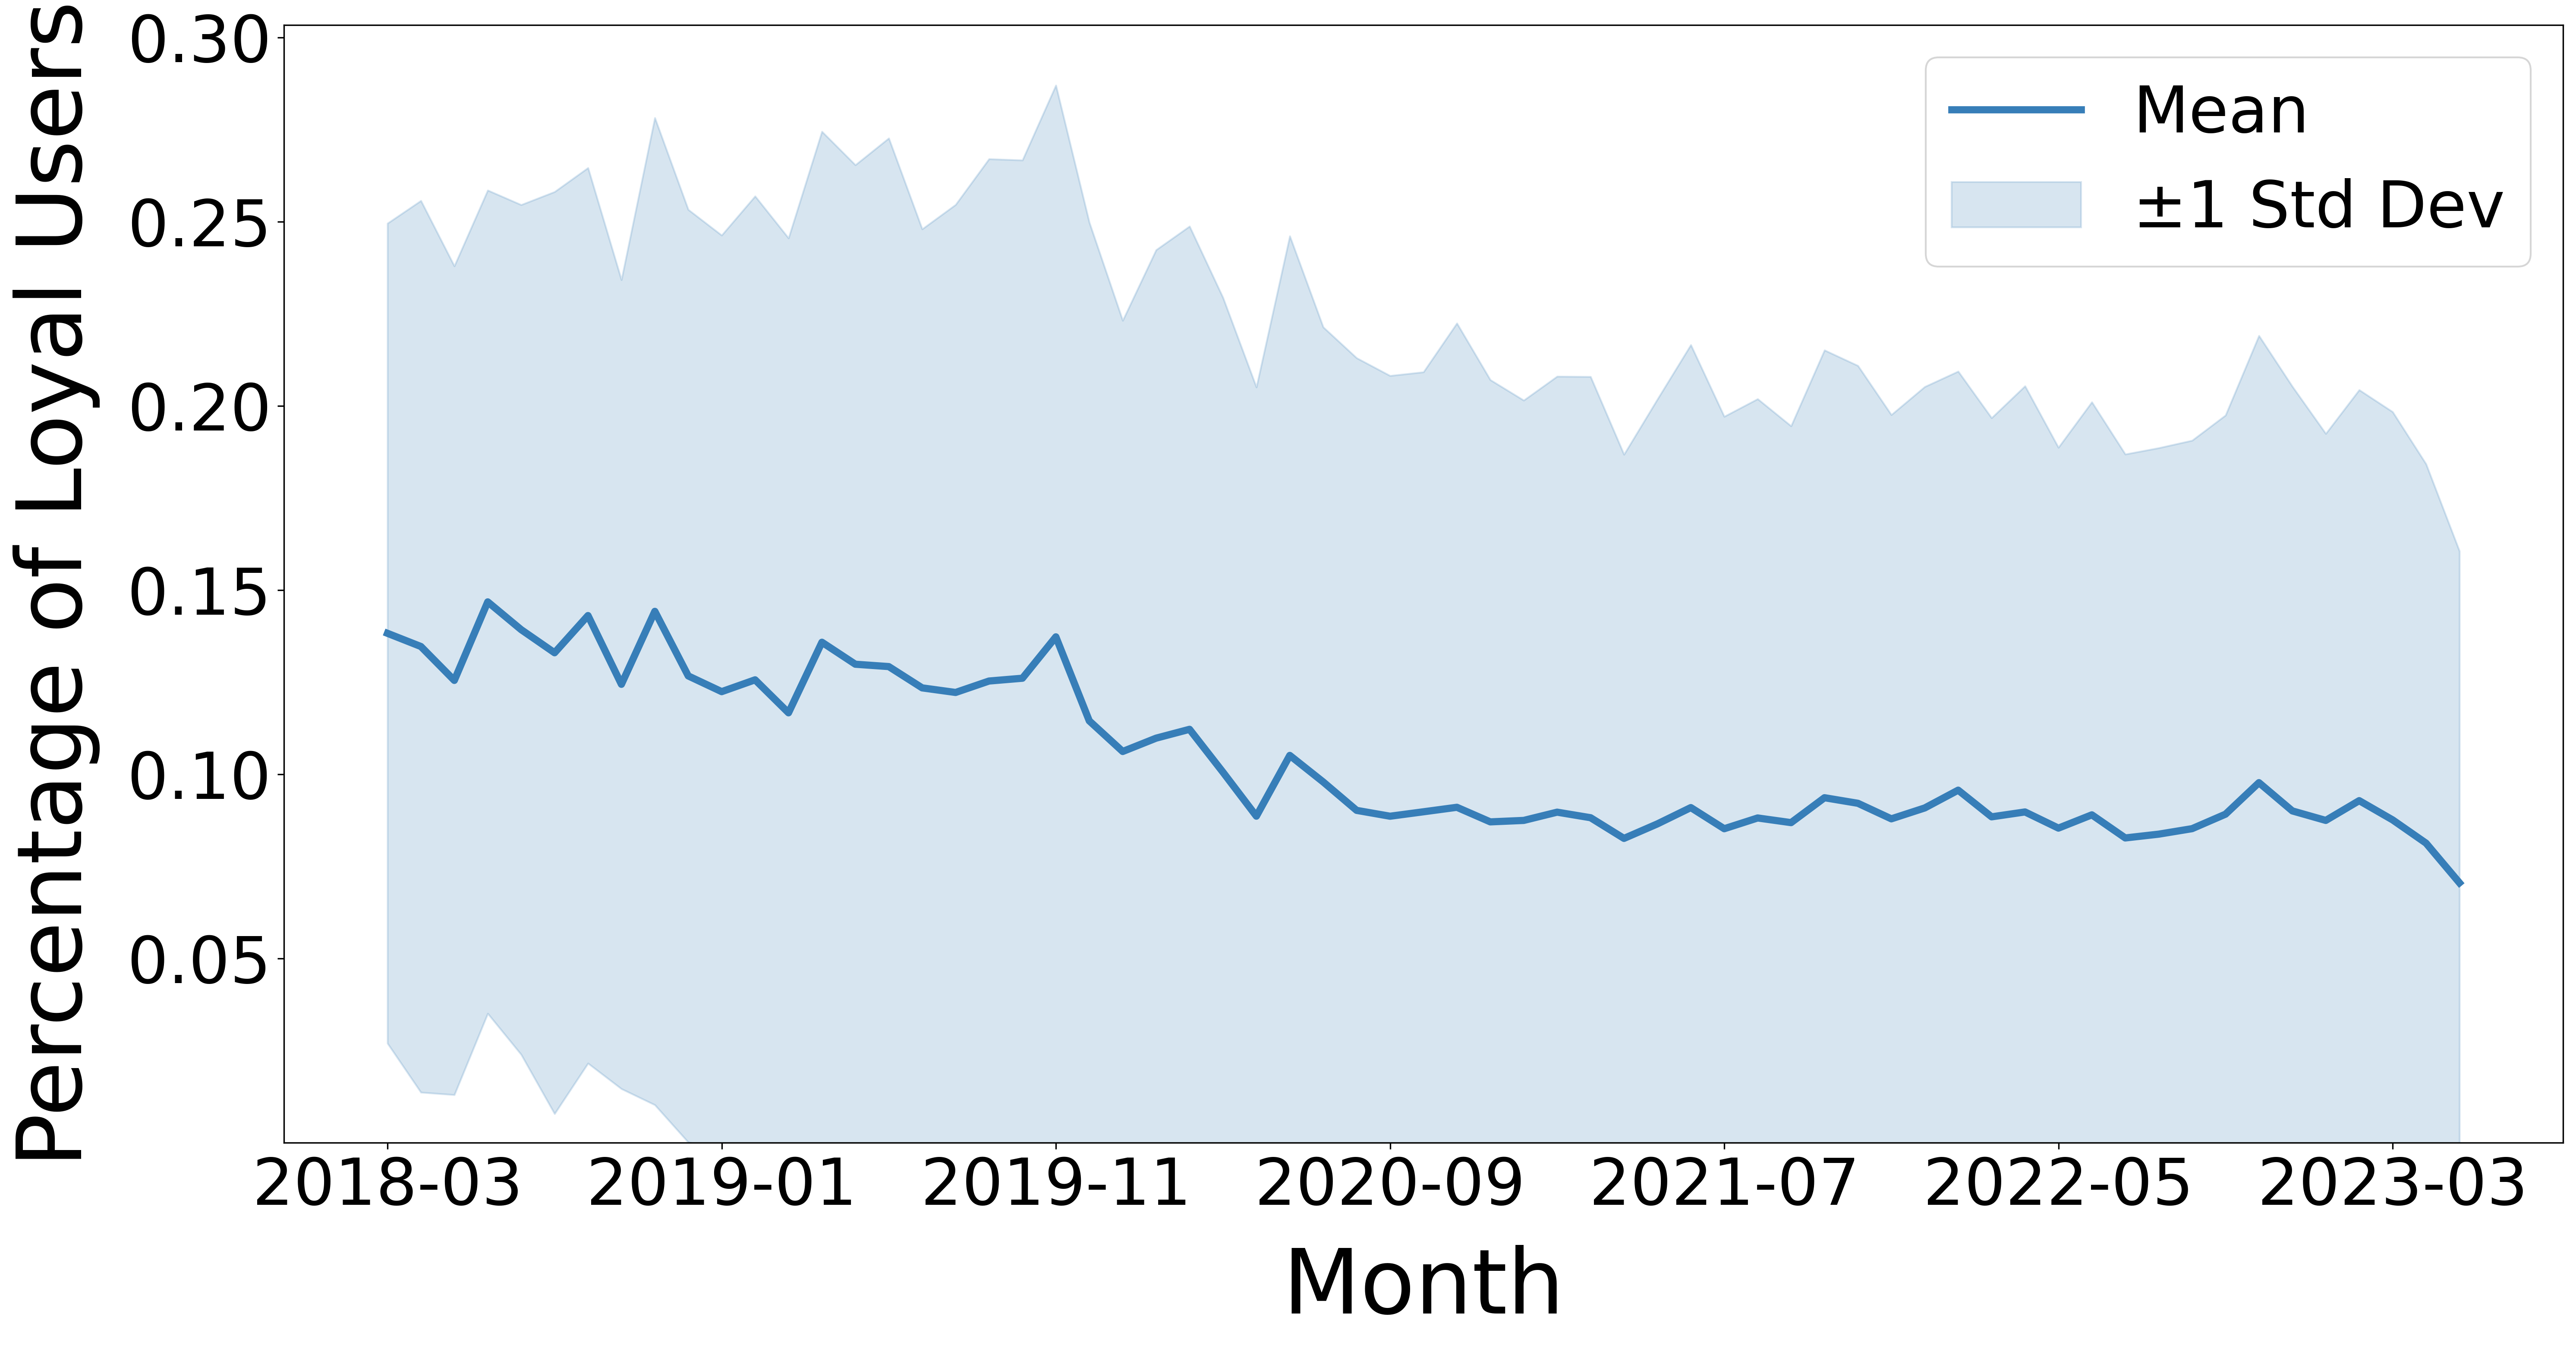

In [4]:
### data import
def jsonl_to_df(jsonl_file_path):
    data = []
    with open(jsonl_file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data.append(json.loads(line))
    df = pd.DataFrame(data)
    return df
df_loyal_user_perc_by_month = jsonl_to_df('data/loyal_users_percentage_stats_per_month.jsonl')[:-3]

# create plot
plt.figure(figsize=(20, 10.5), dpi=300)
plt.plot(df_loyal_user_perc_by_month['month'], df_loyal_user_perc_by_month['mean_loyal_user_percentage_across_vtubers'], label='Mean', color=sns.color_palette("Set1")[1], linewidth=4)
plt.fill_between(df_loyal_user_perc_by_month['month'], 
                 df_loyal_user_perc_by_month['mean_loyal_user_percentage_across_vtubers'] - df_loyal_user_perc_by_month['std_loyal_user_percentage_across_vtubers'], 
                 df_loyal_user_perc_by_month['mean_loyal_user_percentage_across_vtubers'] + df_loyal_user_perc_by_month['std_loyal_user_percentage_across_vtubers'], 
                 color=sns.color_palette("Set1")[1], alpha=0.2, label='±1 Std Dev')
plt.xlabel('Month', fontsize=50, labelpad=15)
plt.ylabel('Percentage of Loyal Users', fontsize=50, labelpad=15)
num_ticks = 6
ticks = df_loyal_user_perc_by_month['month'][::len(df_loyal_user_perc_by_month) // num_ticks].tolist()
plt.xticks(ticks=ticks, rotation=0, fontsize=36)
plt.ylim(0.00001, None)
plt.yticks(fontsize=36)
plt.legend(fontsize=36)
plt.tight_layout()
plt.show()

# Figure 6(b) -- Monthly Average Loyal Viewer Rates for Individual VTubers

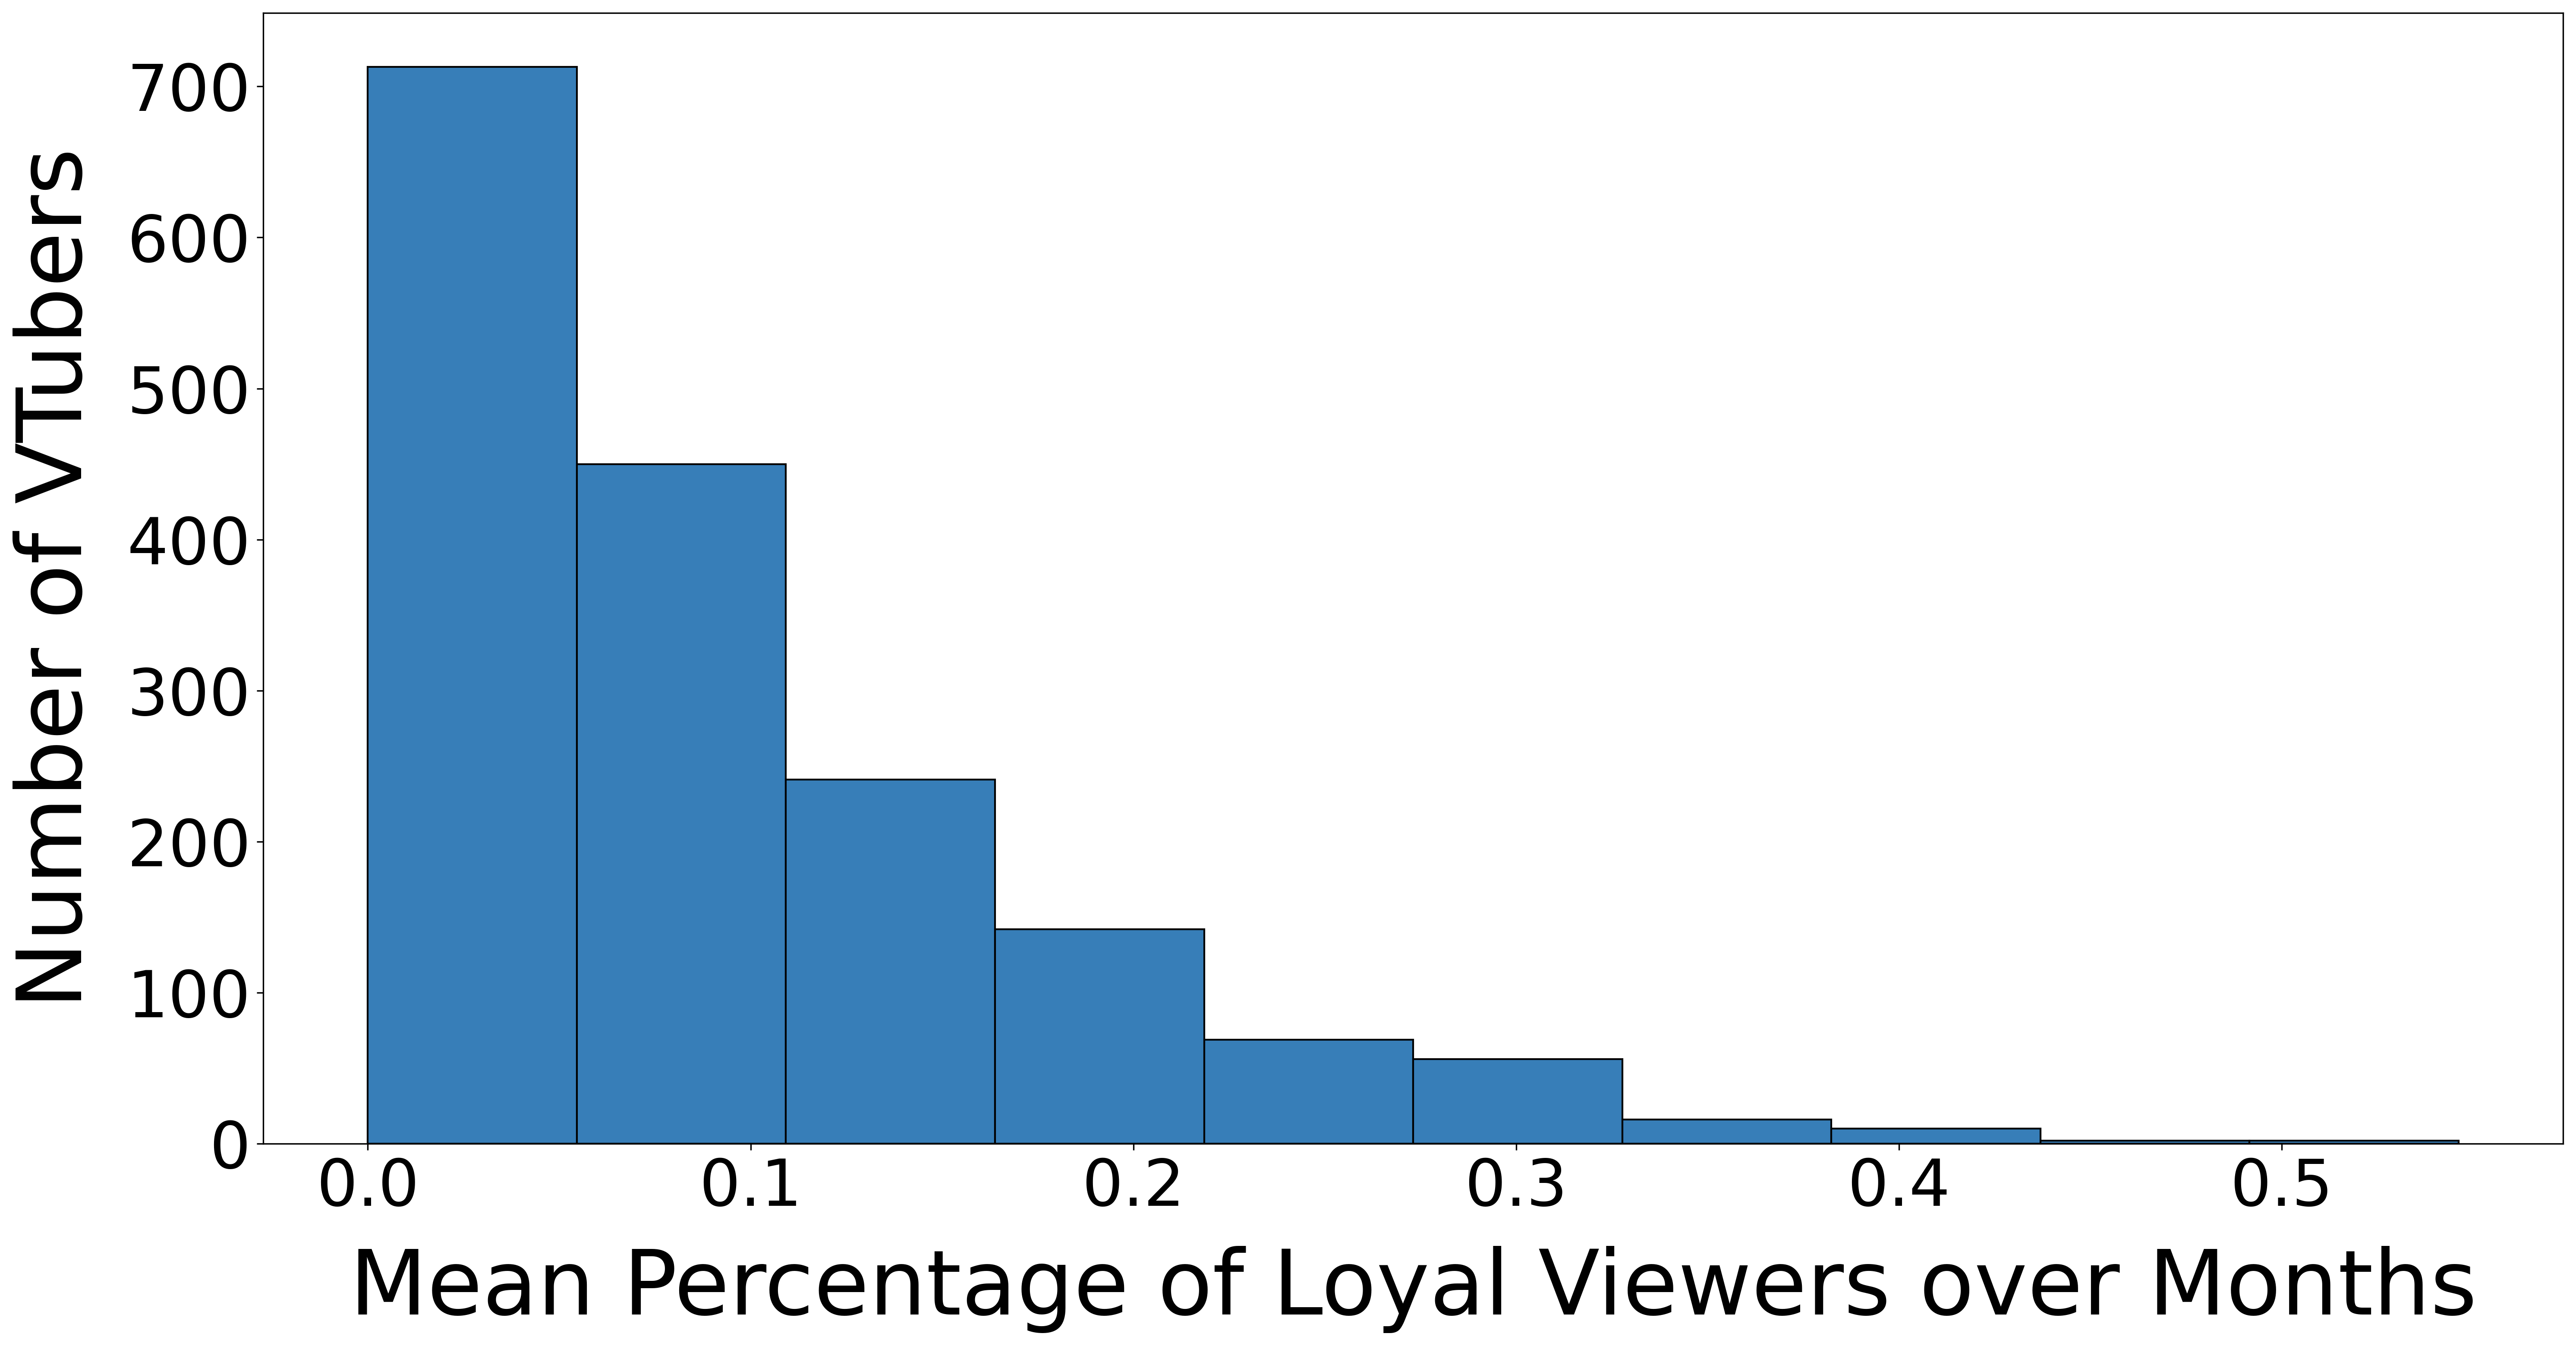

In [5]:
### data import
vtuber_stats = pd.read_csv('data/vtuber_stats.tsv', sep='\t')

### create plot
plt.figure(figsize=(20, 10.5), dpi=300)
plt.hist(vtuber_stats['mean_loyal_user_percentage_over_months'], bins=10, edgecolor='black', color=sns.color_palette("Set1")[1], alpha=1)
plt.xlabel('Mean Percentage of Loyal Viewers over Months', fontsize=50, labelpad=15)
plt.ylabel('Number of VTubers', fontsize=50, labelpad=15)
plt.xticks(fontsize=36)
plt.yticks(fontsize=36)
plt.tight_layout()
plt.show()

# Figure 6(c) -- Distributions of Superchat Sender Ratios for Individual Vtubers

/var/folders/zp/nq2k8xn15_15g53z3mqq0j880000gn/T/ipykernel_92652/3757411967.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


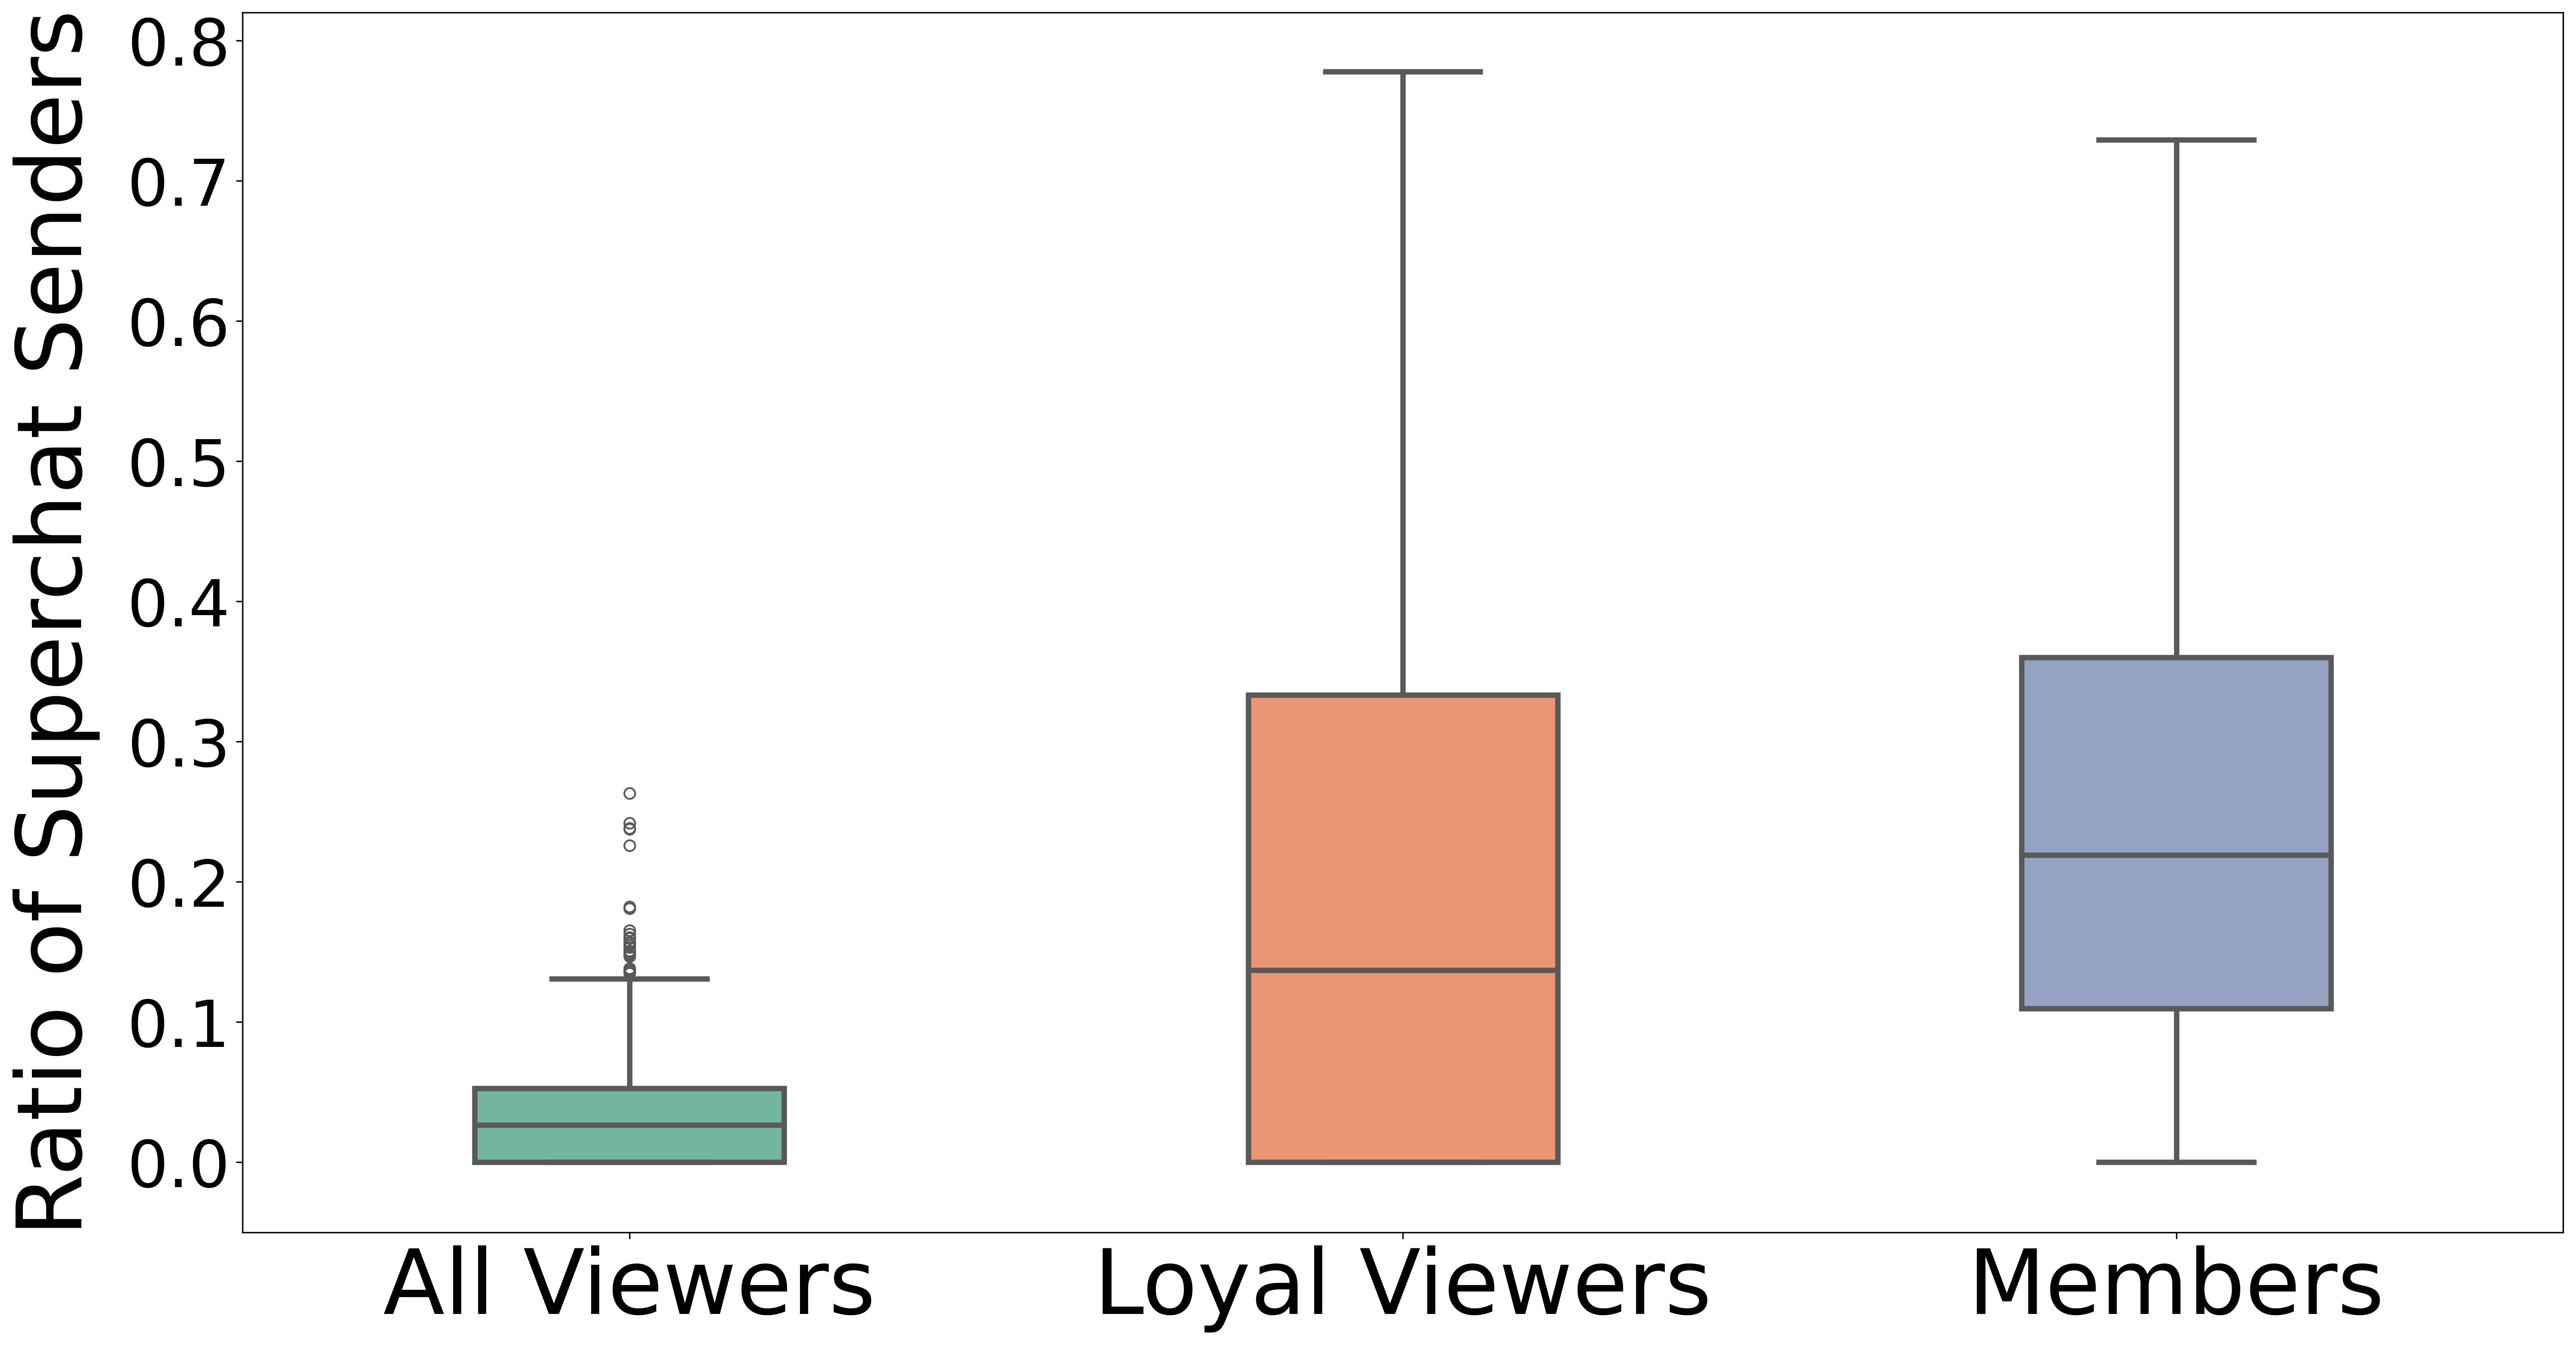

Kruskal-Wallis H-test statistic: 1116.7170, p-value: 3.220926898453938e-243
Significant differences found among the groups.
Pairwise comparisons:
                1              2              3
1   1.000000e+00  4.446966e-112  1.187029e-223
2  4.446966e-112   1.000000e+00   2.819923e-30
3  1.187029e-223   2.819923e-30   1.000000e+00


In [6]:
### data import
vtuber_stats = pd.read_csv('data/vtuber_stats.tsv', sep='\t')
paid_user_ratio_all_viewers = vtuber_stats['paid_user_ratio'].dropna().tolist()
paid_user_ratio_loyal_viewers = vtuber_stats[vtuber_stats['ratio_paid_users_in_loyal_users'] >= 0]['ratio_paid_users_in_loyal_users'].dropna().tolist()
paid_user_ratio_members = vtuber_stats[vtuber_stats['ratio_paid_users_in_members'] >= 0]['ratio_paid_users_in_members'].dropna().tolist()
all_ratios = (
    paid_user_ratio_all_viewers
    + paid_user_ratio_loyal_viewers
    + paid_user_ratio_members
)
categories = (
    ["All Viewers"] * len(paid_user_ratio_all_viewers)
    + ["Loyal Viewers"] * len(paid_user_ratio_loyal_viewers)
    + ["Members"] * len(paid_user_ratio_members)
)

# calculate stats
mean_vals = [
    np.mean(paid_user_ratio_all_viewers),
    np.mean(paid_user_ratio_loyal_viewers),
    np.mean(paid_user_ratio_members),
]

### create plot
plt.figure(figsize=(20, 10.5), dpi=300)
sns.boxplot(
    x=categories,
    y=all_ratios,
    palette="Set2",
    linewidth=3,
    width=0.4,
)
plt.ylabel("Ratio of Superchat Senders", fontsize=50, labelpad=15)
plt.xticks(fontsize=50)
plt.yticks(fontsize=36)
plt.ylim(None, 0.82)
plt.tight_layout()
plt.show()

### statistical test
stat, p = stats.kruskal(paid_user_ratio_all_viewers, 
                        paid_user_ratio_loyal_viewers, 
                        paid_user_ratio_members)
print(f"Kruskal-Wallis H-test statistic: {stat:.4f}, p-value: {p}")

if p < 0.05:
    print("Significant differences found among the groups.")
    data = [paid_user_ratio_all_viewers, paid_user_ratio_loyal_viewers, paid_user_ratio_members]
    posthoc = sp.posthoc_dunn(data, p_adjust='bonferroni')
    print("Pairwise comparisons:\n", posthoc)
else:
    print("No significant differences found among the groups.")

# Figure 7 -- Number of Superchat Senders vs. Gini Index between Superchat Senders

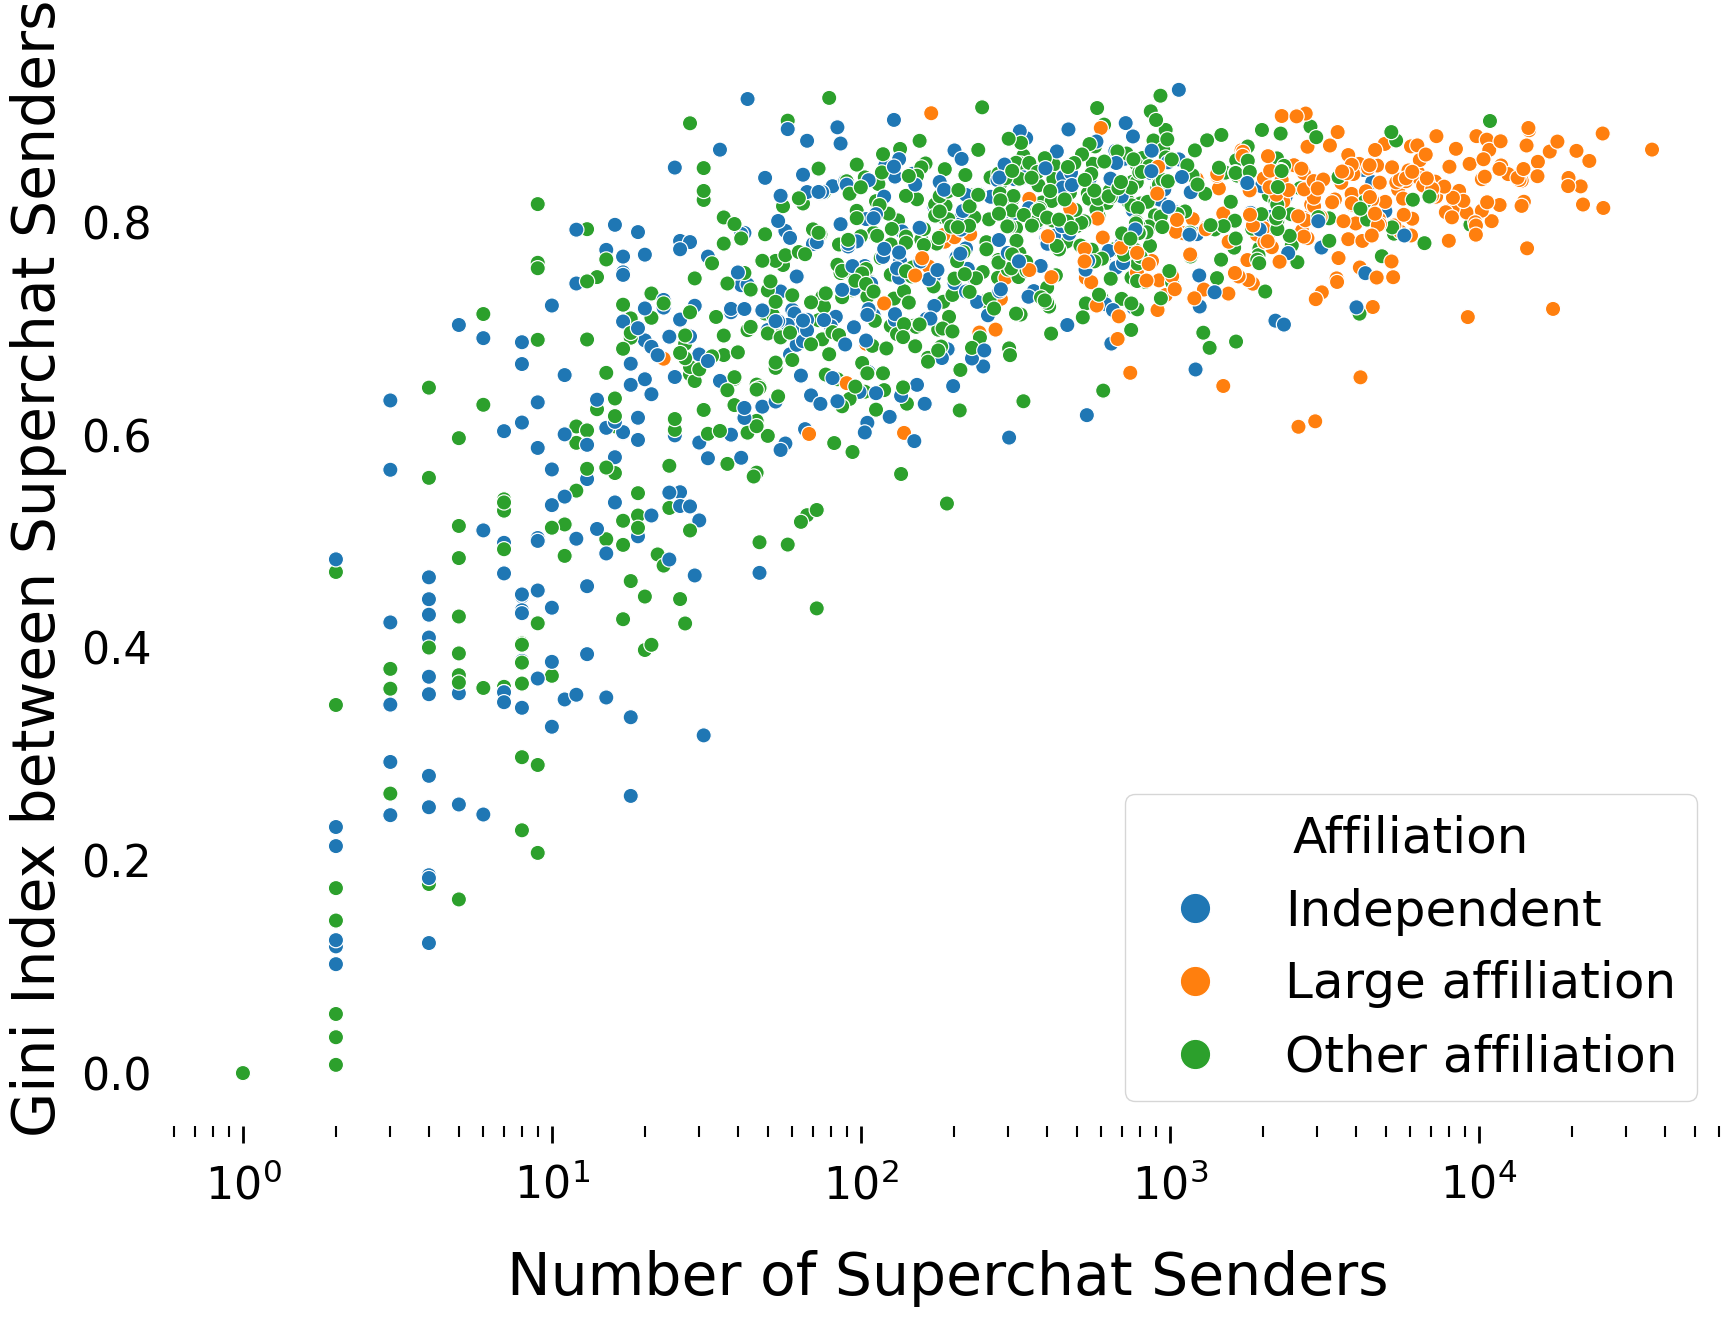

Spearman correlation: 0.7078057540390138, p-value: 3.309293754701501e-191


In [7]:
### data import
vtuber_stats = pd.read_csv('data/vtuber_stats.tsv', sep='\t')
vtuber_gini_income_df = vtuber_stats[vtuber_stats['gini_index_by_user'].notna()]
x = vtuber_gini_income_df['num_paid_users']
y = vtuber_gini_income_df['gini_index_by_user']

### create plot
plt.figure(figsize=(20, 14.5))
hue_order = ['Independent', 'Large affiliation', 'Other affiliation']
sns.scatterplot(data=vtuber_gini_income_df, x='num_paid_users', y='gini_index_by_user', hue='affiliation_type', hue_order=hue_order, color=sns.color_palette("Set1")[1], alpha=1, s=120)
plt.xlabel('Number of Superchat Senders', fontsize=42, labelpad=30)
plt.ylabel('Gini Index between Superchat Senders', fontsize=42, labelpad=10)
plt.xscale('log')
plt.yscale('linear')
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.gca().xaxis.set_tick_params(pad=15, width=2, length=12)
plt.gca().xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs='auto', numticks=10))
plt.gca().xaxis.set_tick_params(which='minor', length=8, width=1.5, color='black')
plt.gca().yaxis.set_tick_params(pad=15, length=0)
plt.ylim(-0.05, 0.99999)
plt.legend(title="Affiliation", title_fontsize=36, fontsize=36, markerscale=2.0)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.show()

### statistical test
df_cleaned = vtuber_stats[['num_paid_users', 'gini_index_by_user']].dropna()
corr, p_value = spearmanr(df_cleaned['num_paid_users'], df_cleaned['gini_index_by_user'])
print(f"Spearman correlation: {corr}, p-value: {p_value}")

# Figure 8 (Left) -- Membership Length

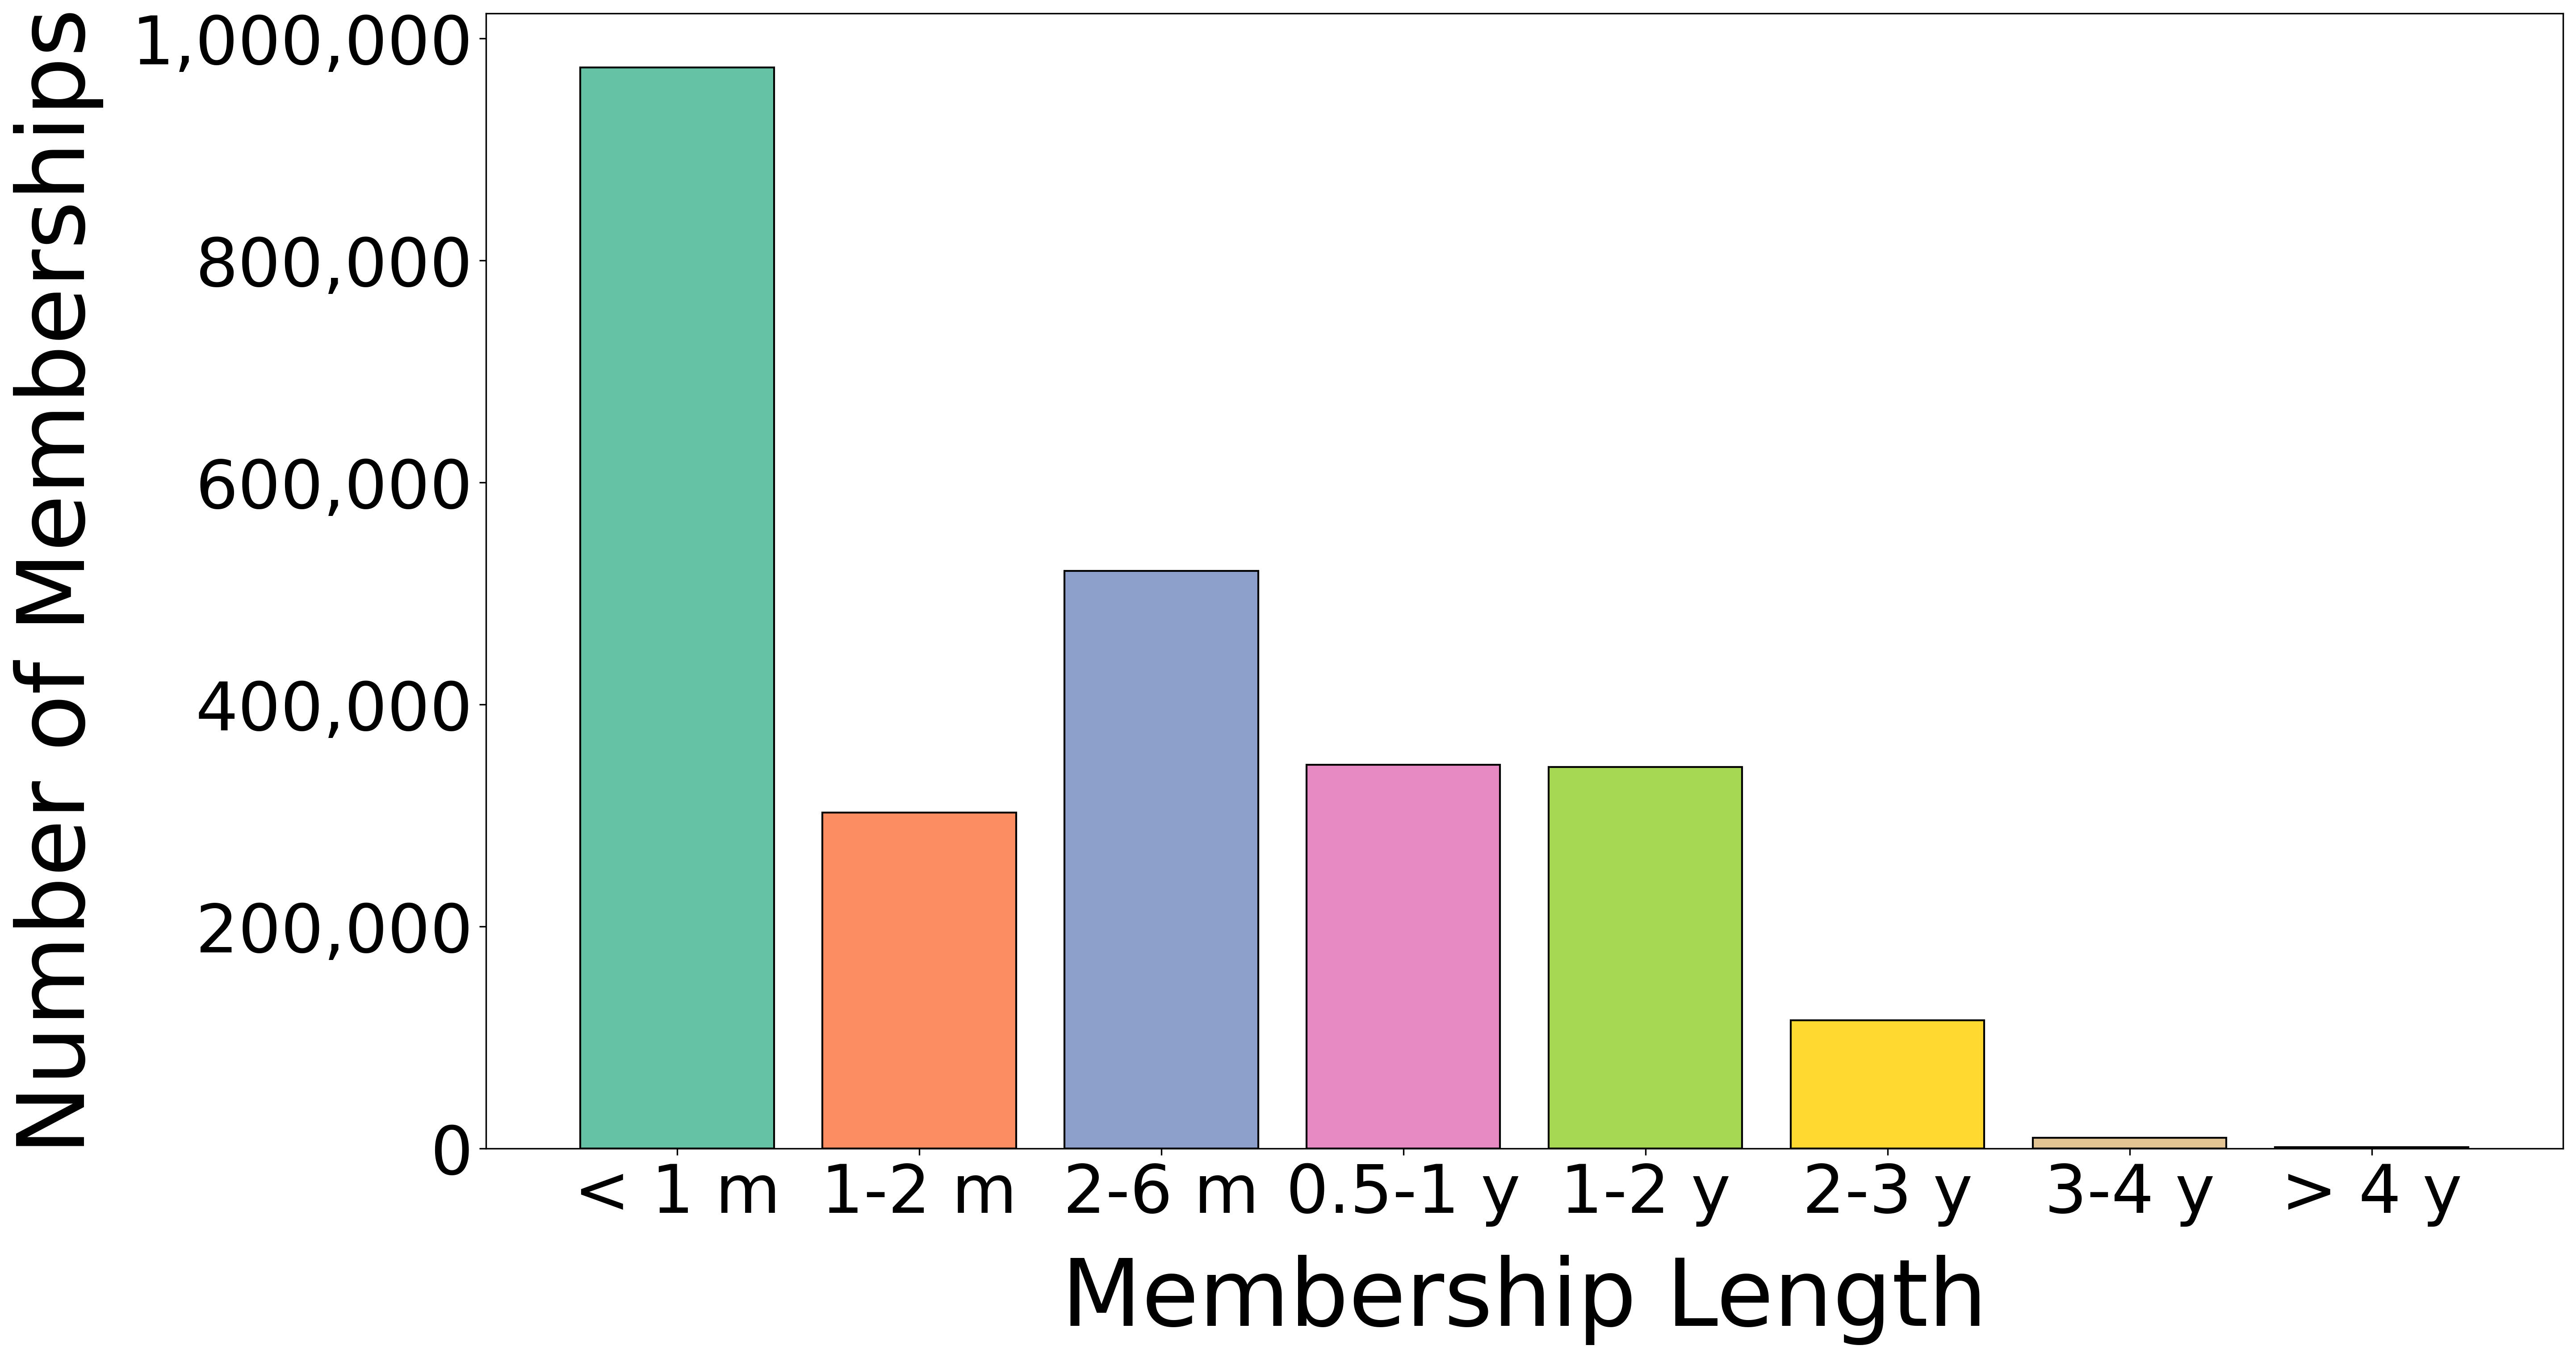

In [8]:
### data import
membership_stats_dict = dict()
with open('data/grouped_membership_status_stats_v5.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        data = json.loads(line)
        membership_stats_dict[data['membership_length']] = data['num_membership']
membership_status = list(membership_stats_dict.keys())
membership_status_counts = list(membership_stats_dict.values())
total_memberships = sum(membership_status_counts)

### Create plot
colors = sns.color_palette("Set2")
plt.figure(figsize=(20, 11), dpi=300)
bars = plt.bar(membership_status, membership_status_counts, color=colors, edgecolor='black')
plt.xlabel('Membership Length', fontsize=50, labelpad=15)
plt.ylabel('Number of Memberships', fontsize=50, labelpad=15)
plt.xticks(fontsize=36)
plt.yticks(fontsize=36)
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()

# Figure 8 (Right) -- Number of VTubers Viewers Subscribed to

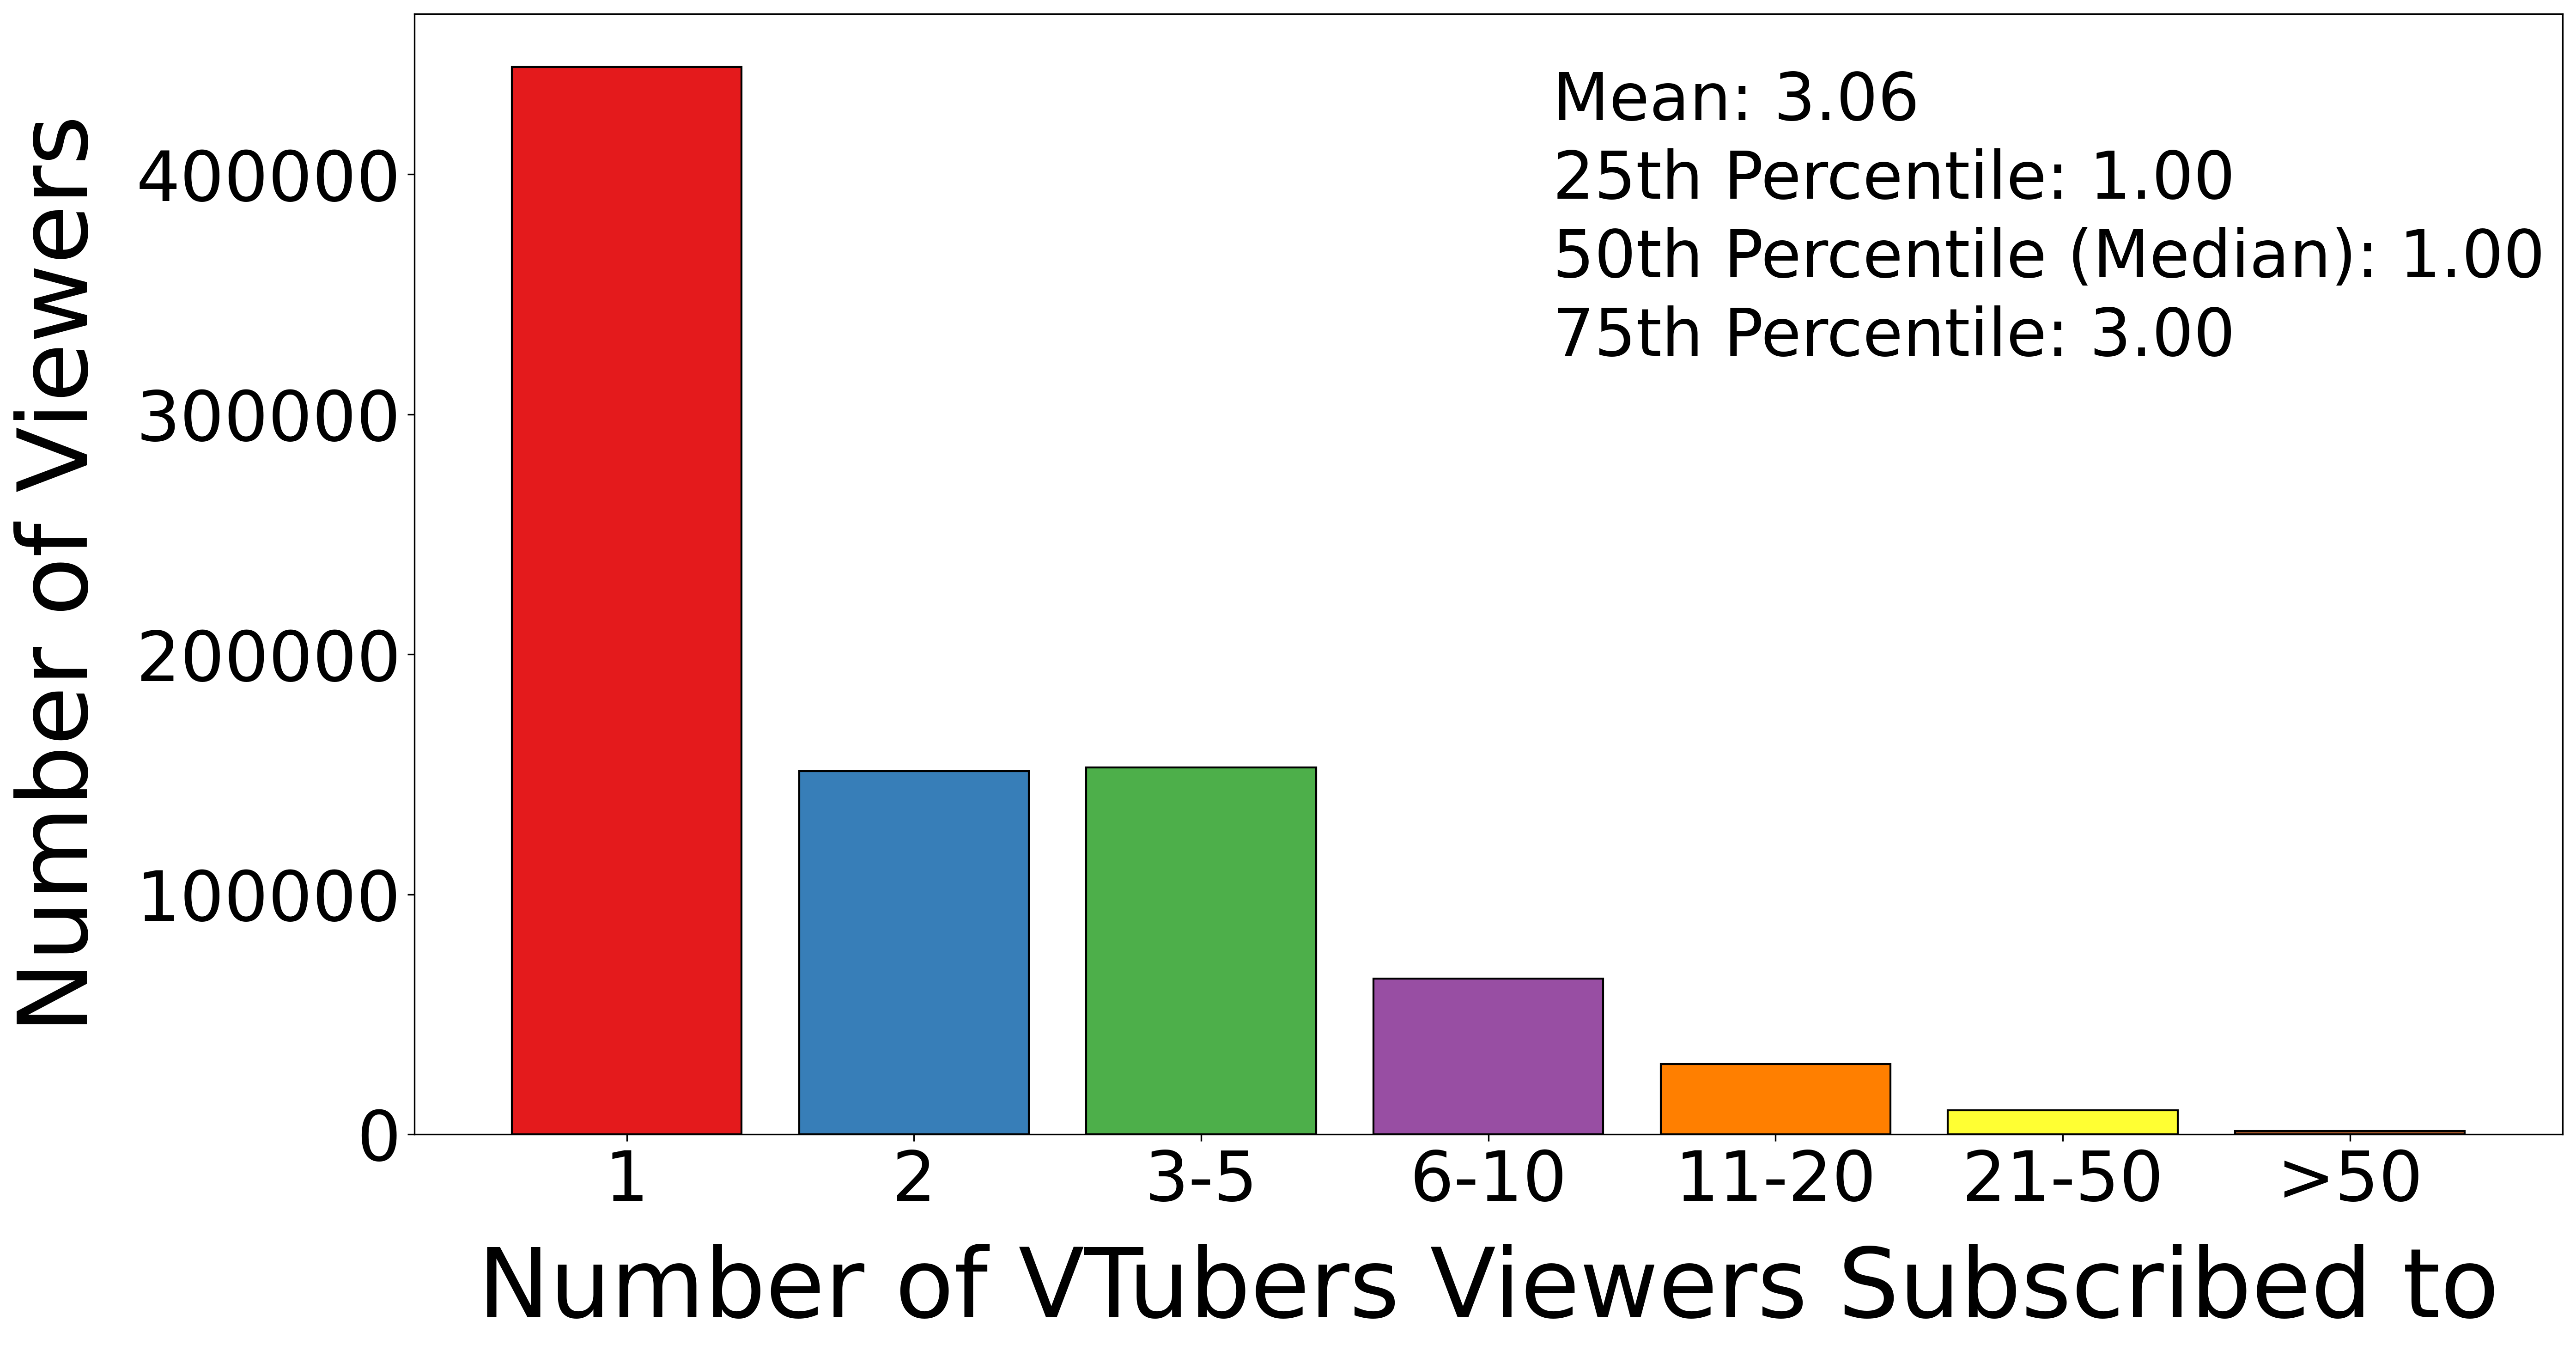

In [9]:
### data import 
num_vtubers_subscribed_to = []
with open('data/num_of_vtubers_subscribed_to.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        data = json.loads(line)
        num_vtubers_subscribed_to.extend([data['num_of_vtubers_users_subscribed_to']] * data['num_users'])
        
num_vtubers_subscribed_to = np.array(num_vtubers_subscribed_to)
num_vtubers_subscribed_to_dict = defaultdict(int)
for num in num_vtubers_subscribed_to:
    if num == 1:
        num_vtubers_subscribed_to_dict['1'] += 1
    elif num == 2:
        num_vtubers_subscribed_to_dict['2'] += 1
    elif 3 <= num <= 5:
        num_vtubers_subscribed_to_dict['3-5'] += 1
    elif 6 <= num <= 10:
        num_vtubers_subscribed_to_dict['6-10'] += 1
    elif 11 <= num <= 20:
        num_vtubers_subscribed_to_dict['11-20'] += 1
    elif 21 <= num <= 50:
        num_vtubers_subscribed_to_dict['21-50'] += 1
    else:
        num_vtubers_subscribed_to_dict['>50'] += 1
num_vtubers_keys = list(num_vtubers_subscribed_to_dict.keys())
num_vtubers_list = list(num_vtubers_subscribed_to_dict.values())
total_memberships = sum(num_vtubers_list)

### Compute stats
mean_num_vtubers_subscribed_to = np.mean(num_vtubers_subscribed_to)
percentile_25 = np.percentile(num_vtubers_subscribed_to, 25)
percentile_50 = np.percentile(num_vtubers_subscribed_to, 50)
percentile_75 = np.percentile(num_vtubers_subscribed_to, 75)

### Create plot
colors = sns.color_palette("Set1")
plt.figure(figsize=(20, 10.5), dpi=300)
bars = plt.bar(num_vtubers_keys, num_vtubers_list, color=colors, edgecolor='black')
plt.text(0.53, 0.95, f'Mean: {mean_num_vtubers_subscribed_to:.2f}', color='black',
         verticalalignment='top', fontsize=34, transform=plt.gca().transAxes)
plt.text(0.53, 0.88, f'25th Percentile: {percentile_25:.2f}', color='black',
         verticalalignment='top', fontsize=34, transform=plt.gca().transAxes)
plt.text(0.53, 0.81, f'50th Percentile (Median): {percentile_50:.2f}', color='black',
         verticalalignment='top', fontsize=34, transform=plt.gca().transAxes)
plt.text(0.53, 0.74, f'75th Percentile: {percentile_75:.2f}', color='black',
         verticalalignment='top', fontsize=34, transform=plt.gca().transAxes)
plt.xlabel('Number of VTubers Viewers Subscribed to', fontsize=50, labelpad=15)
plt.ylabel('Number of Viewers', fontsize=50, labelpad=15)
plt.xticks(fontsize=36)
plt.yticks(fontsize=36)
plt.show()

# Figure 9 (Left) -- Loyal Viewer Ratio vs. Ratio of Superchat Income Contributed by Loyal Viewers 

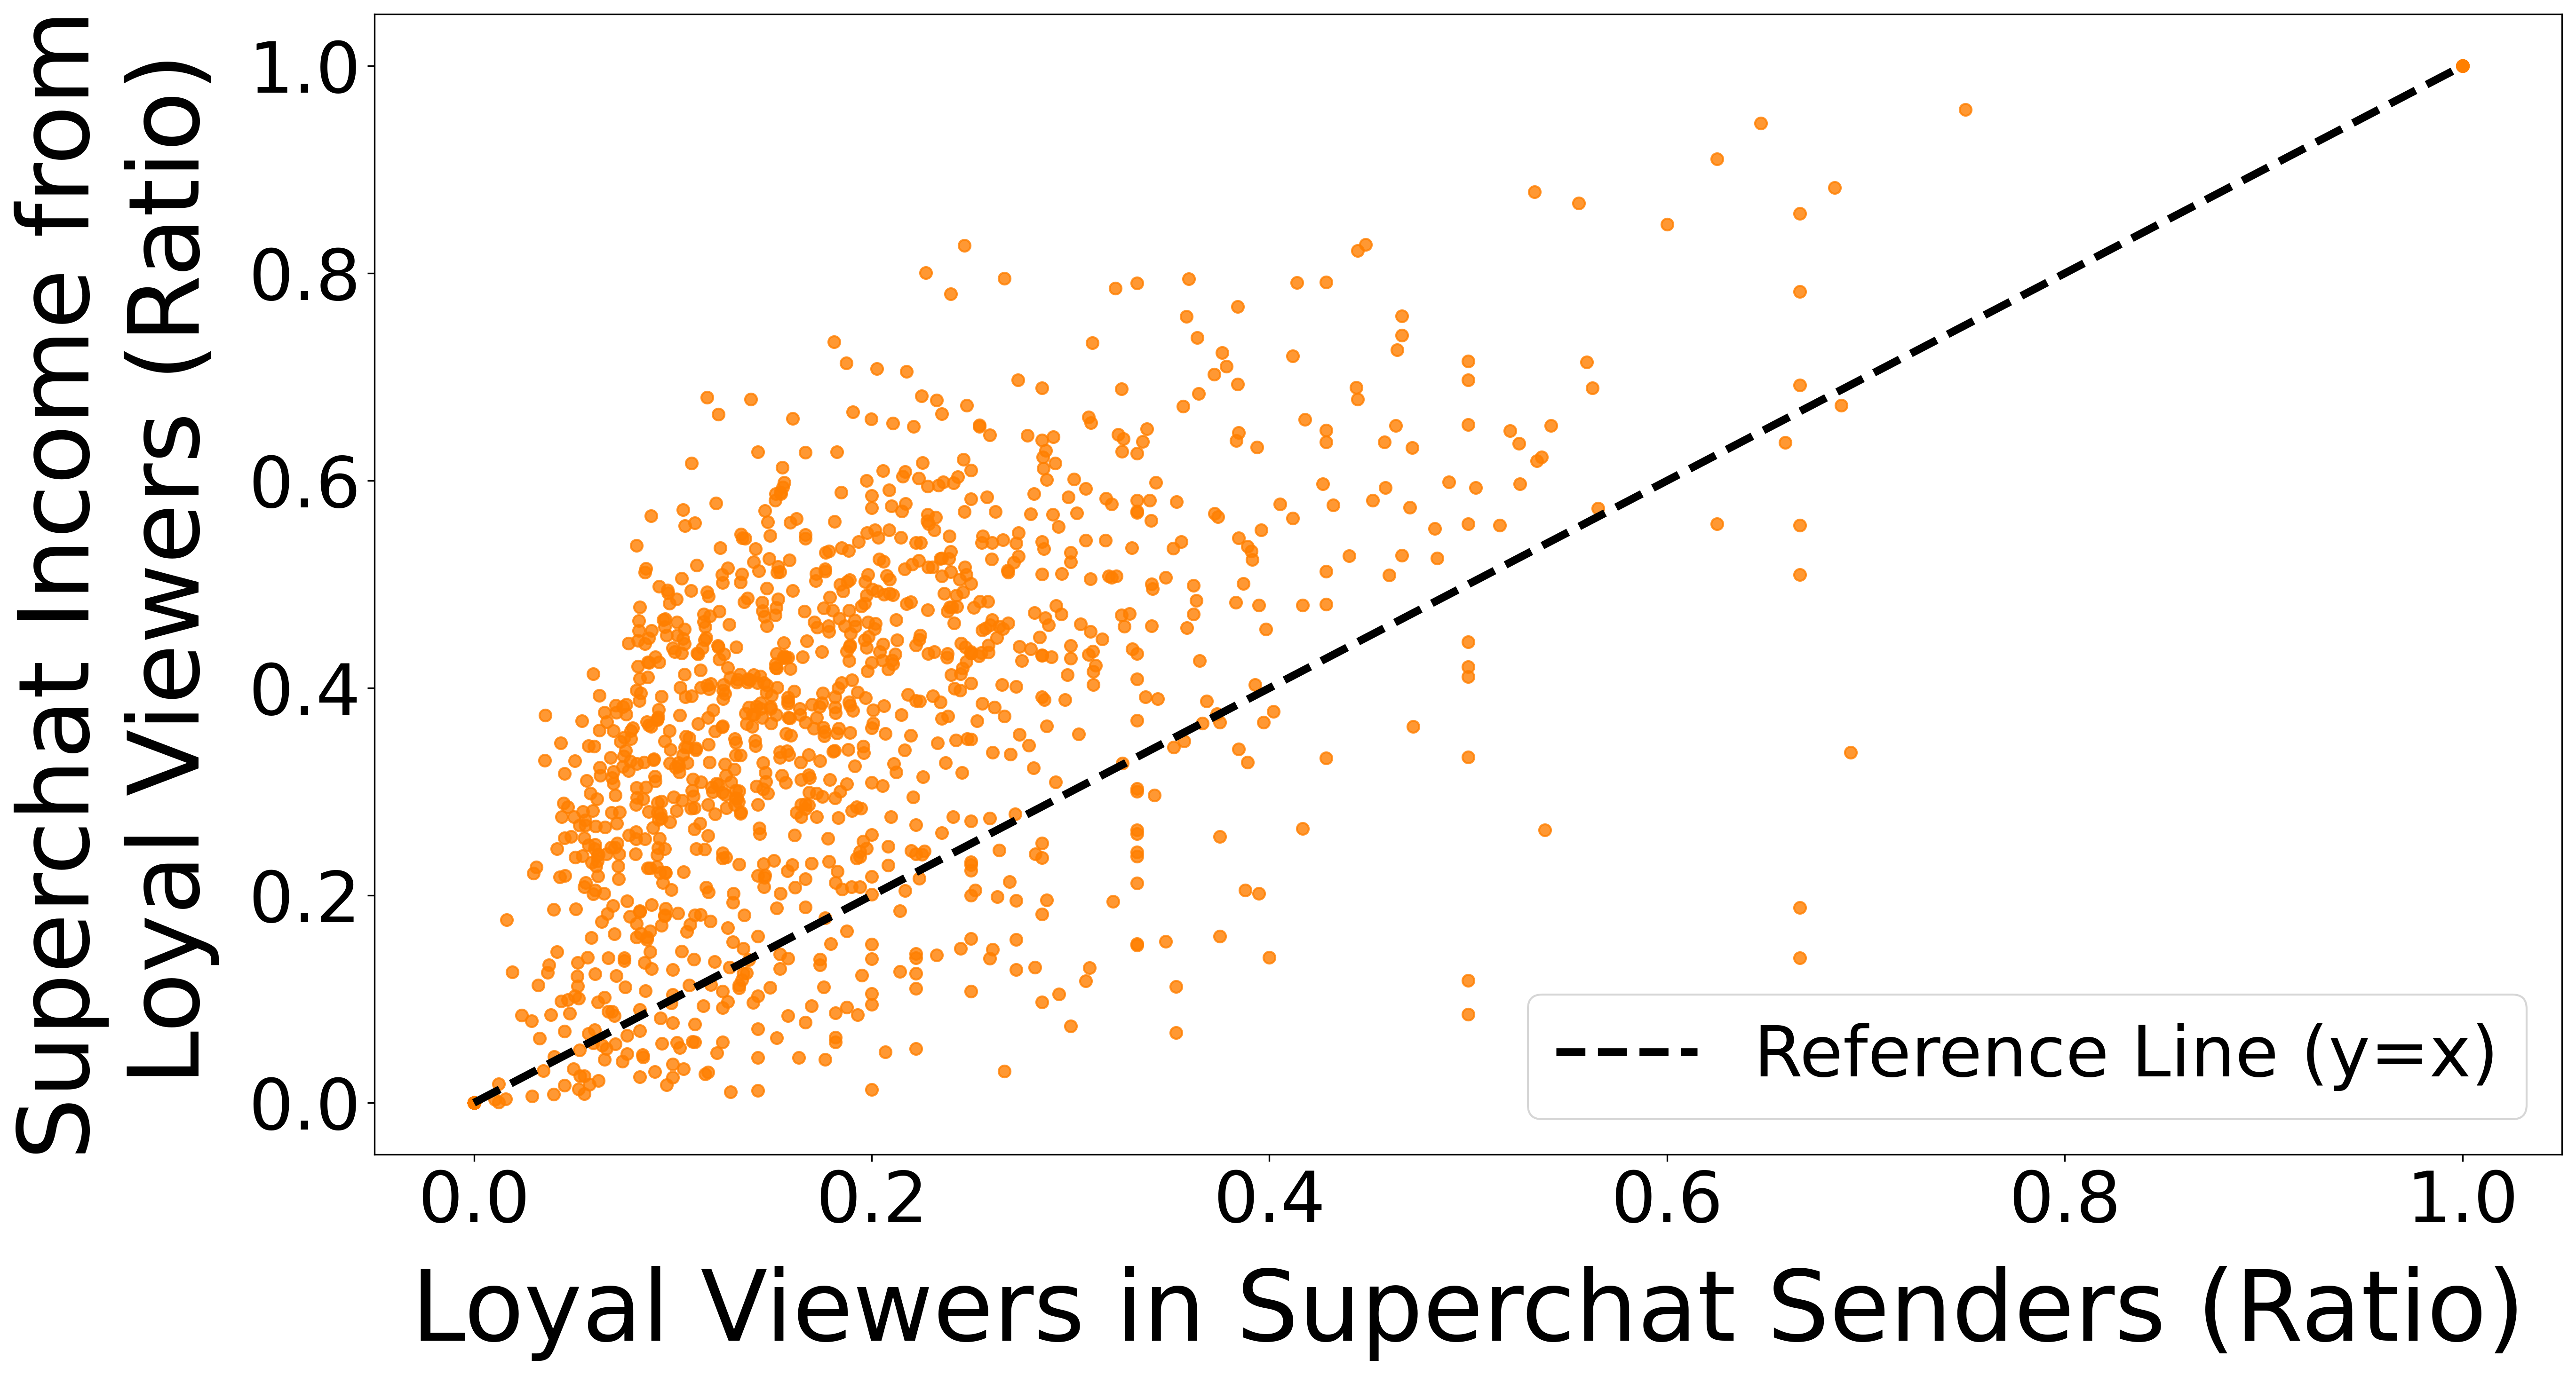

In [10]:
### data import
vtuber_stats = pd.read_csv('data/vtuber_stats.tsv', sep='\t')
df = vtuber_stats[['ratio_loyal_users_in_paid_users', 'ratio_payment_by_loyal_users']].replace([np.inf, -np.inf], np.nan).dropna()

### Create plot
plt.figure(figsize=(20, 10.5), dpi=300)
plt.scatter(
    df['ratio_loyal_users_in_paid_users'], 
    df['ratio_payment_by_loyal_users'], 
    color=sns.color_palette("Set1")[4], 
    alpha=0.8,
)
min_value = min(df['ratio_loyal_users_in_paid_users'].min(), df['ratio_payment_by_loyal_users'].min())
max_value = max(df['ratio_loyal_users_in_paid_users'].max(), df['ratio_payment_by_loyal_users'].max())
plt.plot(
    [min_value, max_value], 
    [min_value, max_value], 
    color='black', 
    linestyle='--', 
    label='Reference Line (y=x)',
    linewidth=4
)
plt.xlabel('Loyal Viewers in Superchat Senders (Ratio)', fontsize=50, labelpad=15)
plt.ylabel('Superchat Income from\n Loyal Viewers (Ratio)', fontsize=50, labelpad=15)
plt.legend(loc='lower right',  fontsize=36)
plt.grid(False)
plt.gca().set_facecolor('white')
plt.xticks(fontsize=36)
plt.yticks(fontsize=36)
plt.show()

# Figure 9 (Middle) -- Member Ratio vs. Ratio of Superchat Income Contributed by members 

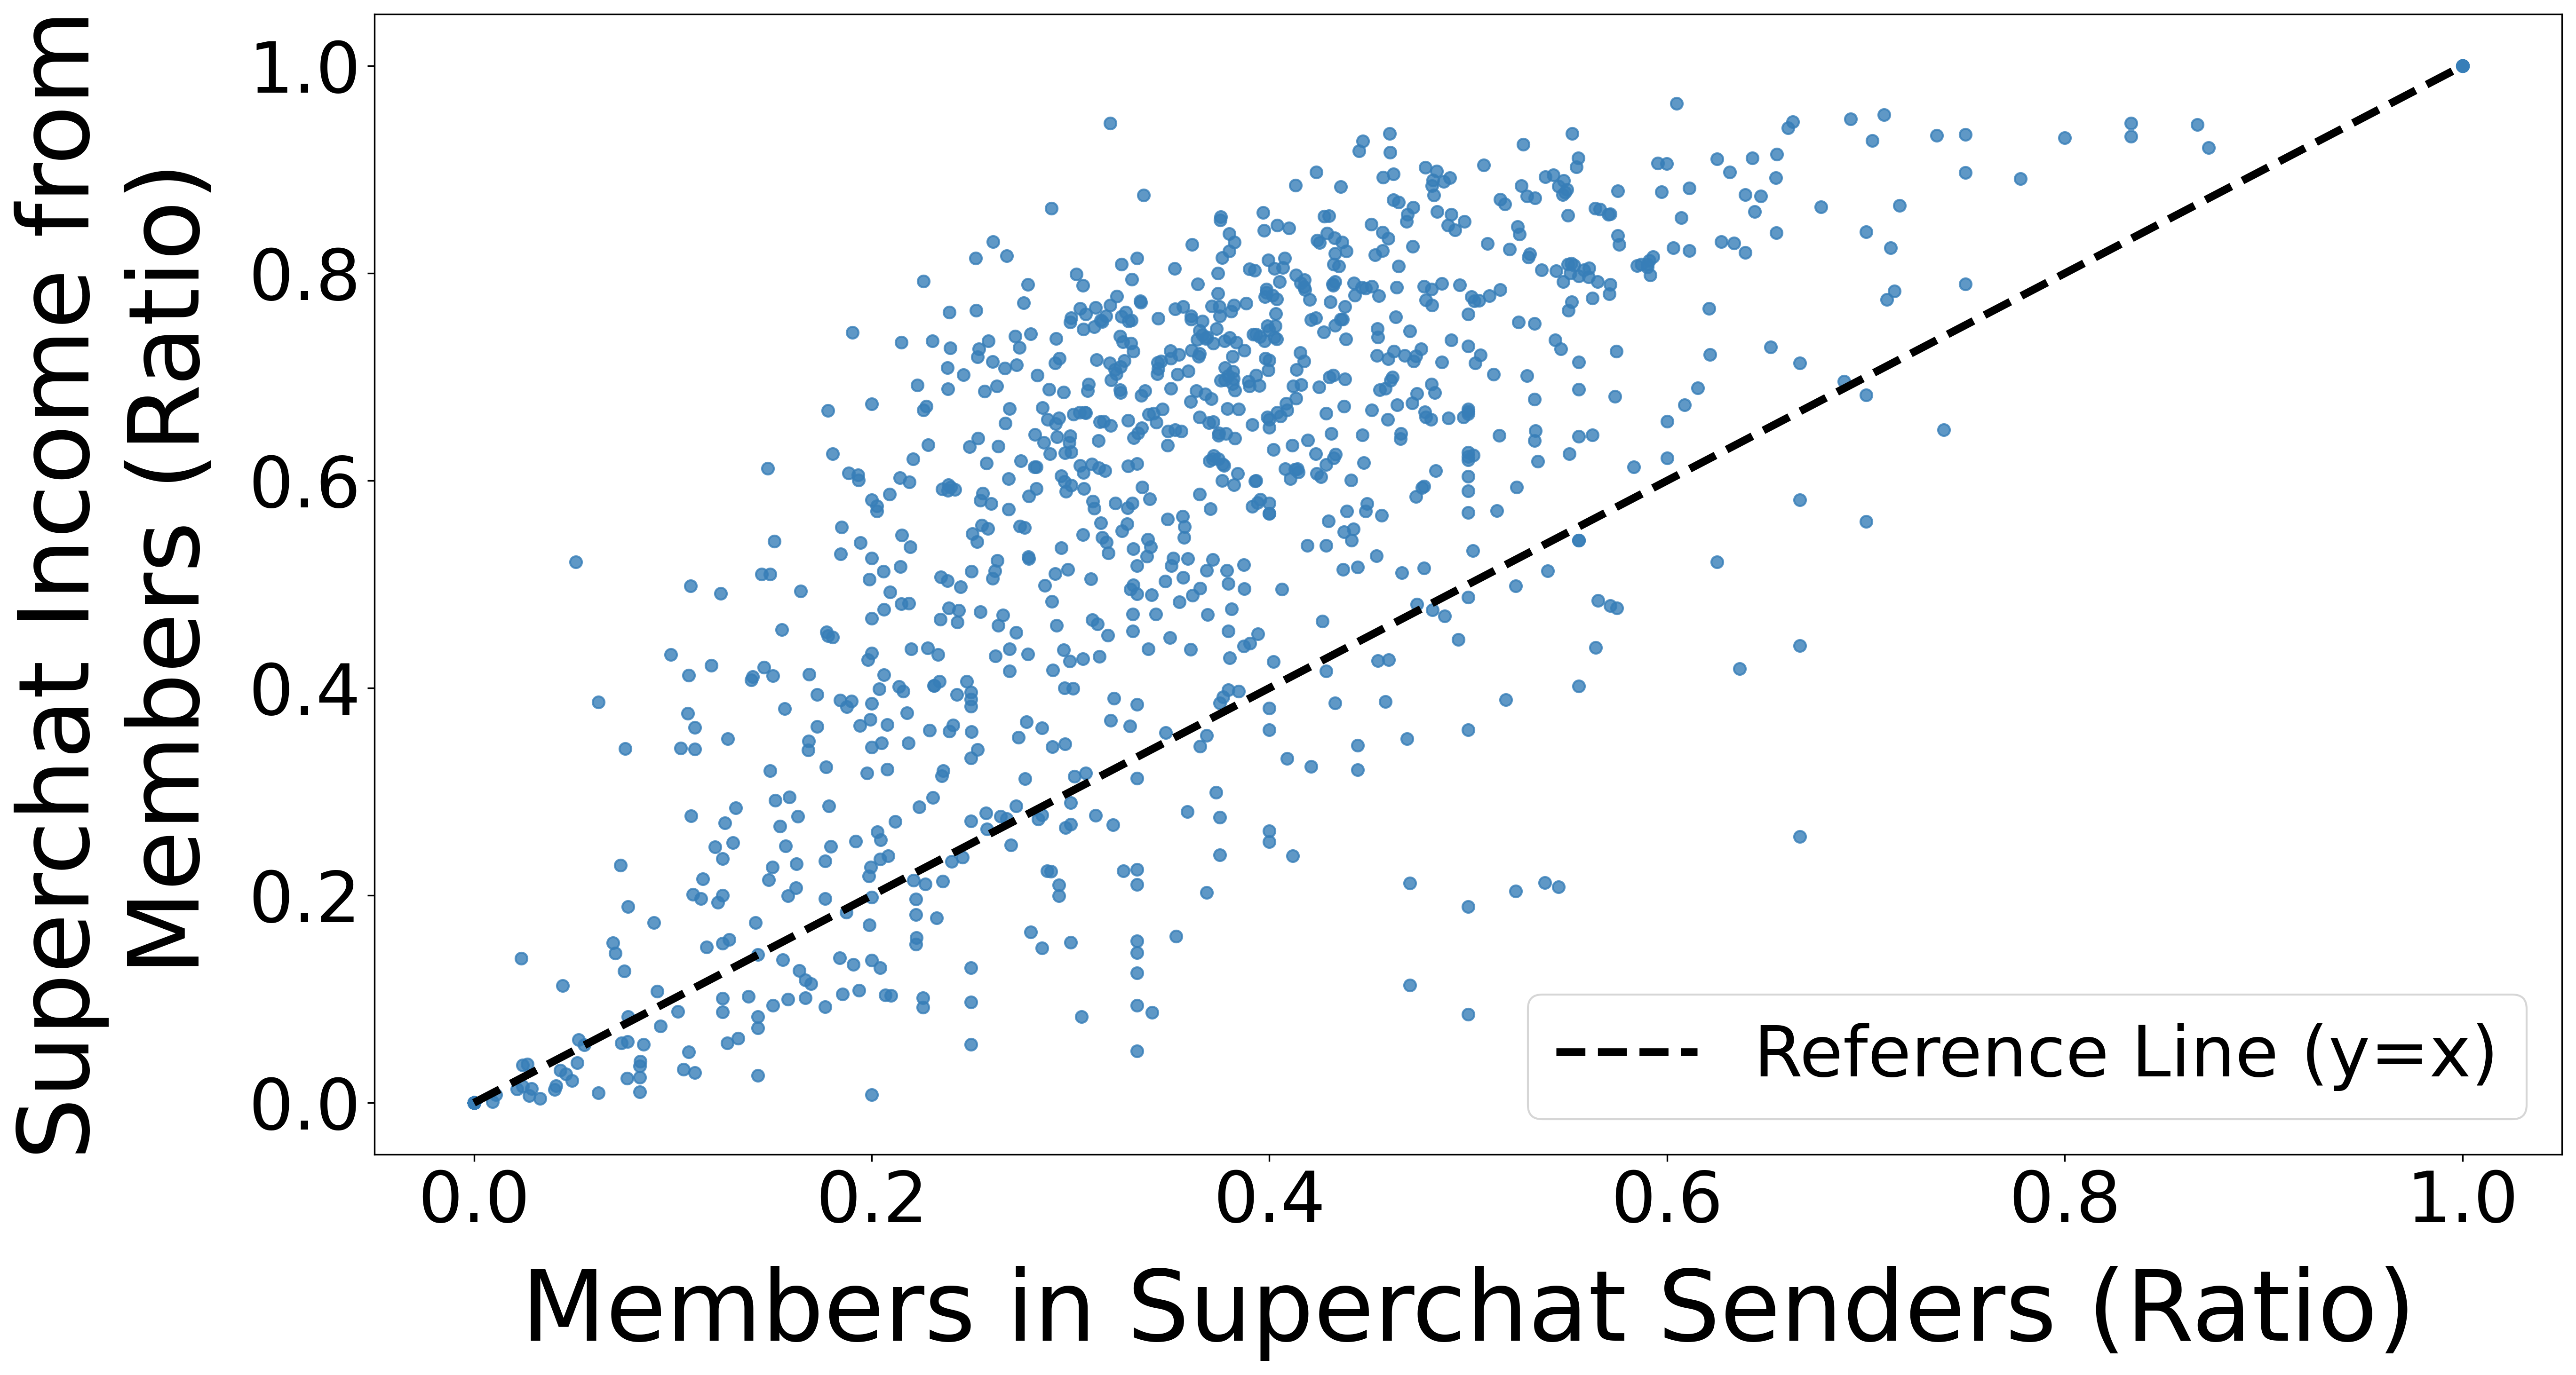

In [11]:
### data import
vtuber_stats = pd.read_csv('data/vtuber_stats.tsv', sep='\t')
df = vtuber_stats[['ratio_members_in_paid_users', 'ratio_payment_by_members']].replace([np.inf, -np.inf], np.nan).dropna()

### Create plot
plt.figure(figsize=(20, 10.5), dpi=300)
plt.scatter(
    df['ratio_members_in_paid_users'], 
    df['ratio_payment_by_members'], 
    color=sns.color_palette("Set1")[1], 
    alpha=0.8,
)
min_value = min(df['ratio_members_in_paid_users'].min(), df['ratio_payment_by_members'].min())
max_value = max(df['ratio_members_in_paid_users'].max(), df['ratio_payment_by_members'].max())
plt.plot(
    [min_value, max_value], 
    [min_value, max_value], 
    color='black', 
    linestyle='--', 
    label='Reference Line (y=x)',
    linewidth=4
)
plt.xlabel('Members in Superchat Senders (Ratio)', fontsize=50, labelpad=15)
plt.ylabel('Superchat Income from\n Members (Ratio)', fontsize=50, labelpad=15)
plt.legend(loc='lower right',  fontsize=36)
plt.grid(False)
plt.gca().set_facecolor('white')
plt.xticks(fontsize=36)
plt.yticks(fontsize=36)
plt.show()

# Figure 10(a) -- Statistics of Loyal Viewers’ Superchat Income Contributions

/var/folders/zp/nq2k8xn15_15g53z3mqq0j880000gn/T/ipykernel_92652/3118294742.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Loyal Viewers   ', '   Non-Loyal Viewers'], fontsize=38)
/var/folders/zp/nq2k8xn15_15g53z3mqq0j880000gn/T/ipykernel_92652/3118294742.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Loyal Viewers   ', '   Non-Loyal Viewers'], fontsize=38)
/var/folders/zp/nq2k8xn15_15g53z3mqq0j880000gn/T/ipykernel_92652/3118294742.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(['Loyal Viewers   ', '   Non-Loyal Viewers'], fontsize=38)


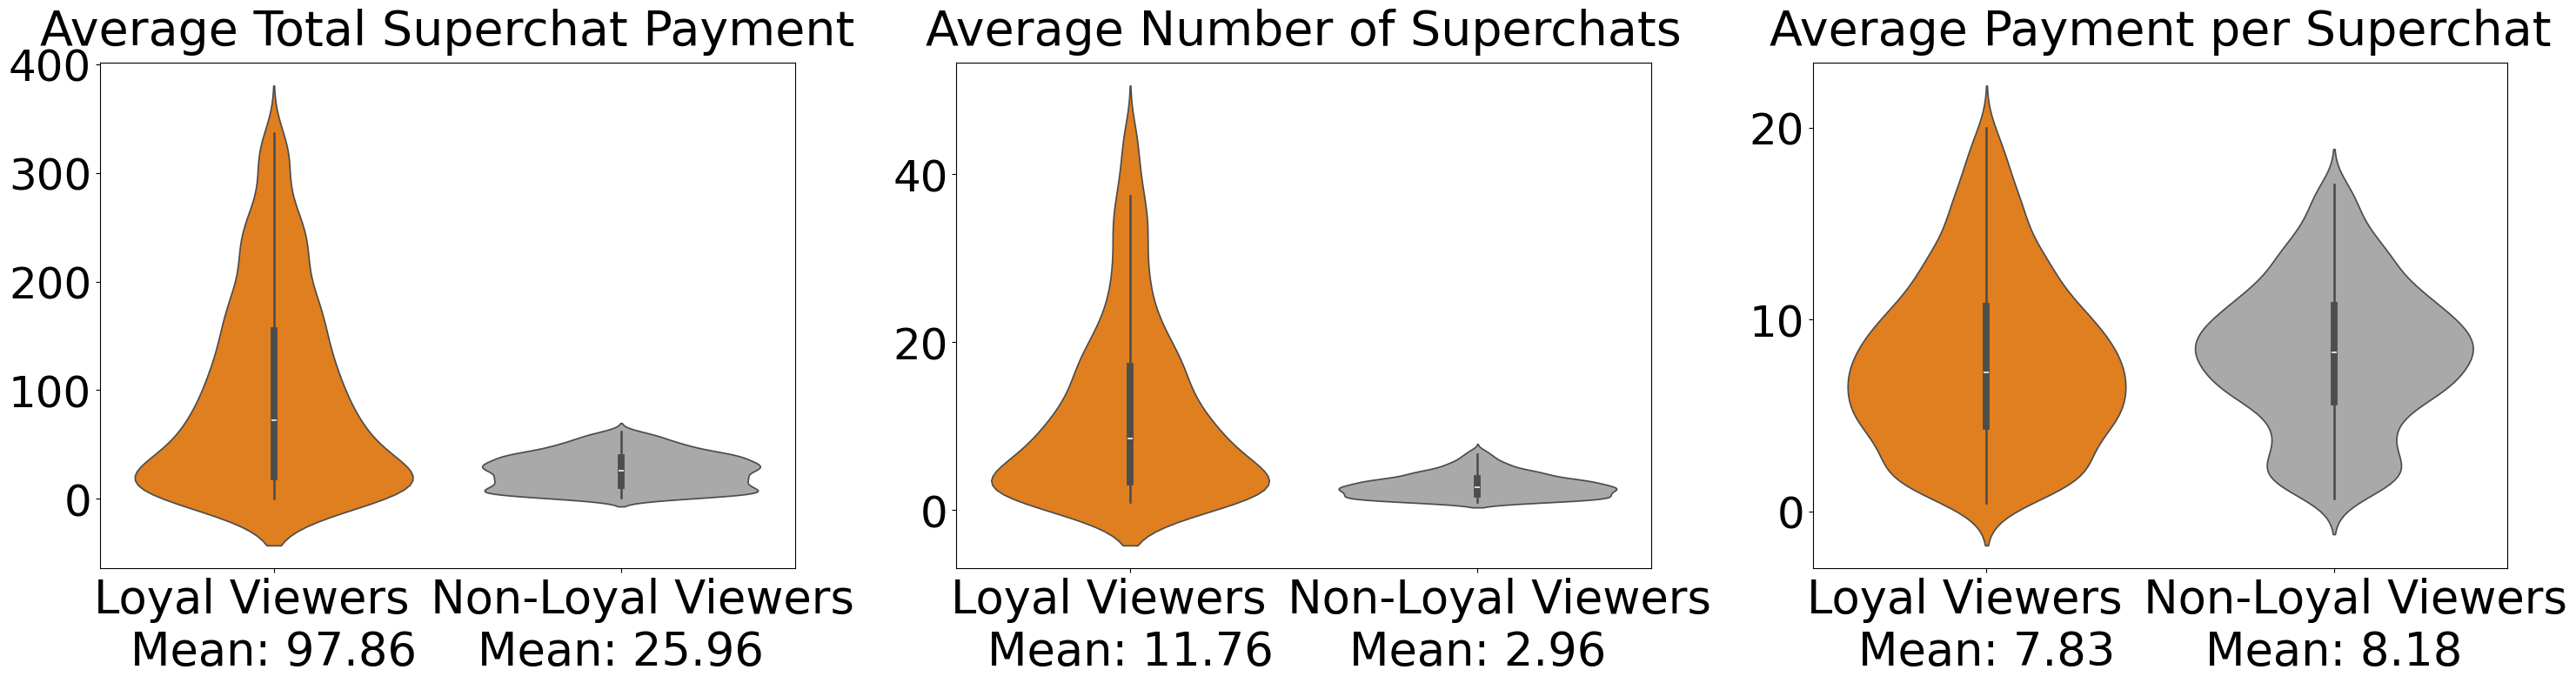

average payment of loyal vs. non-loyal userss
Wilcoxon signed-rank test: statistic=30874.0, p-value=9.550606732348189e-159

average number of paid chats of loyal vs. non-loyal users
Wilcoxon signed-rank test: statistic=13448.5, p-value=7.561425182798739e-174

average payment per chat of loyal vs. non-loyal users
Wilcoxon signed-rank test: statistic=272609.0, p-value=1.1836785227351145e-08


In [12]:
# Function to remove top 5% of values
def remove_top_5_percent(data):
    data = data.replace([np.inf, -np.inf], np.nan).dropna()
    upper_limit = np.percentile(data, 95)
    return [x for x in data if x <= upper_limit]

### data import
vtuber_stats = pd.read_csv('data/vtuber_stats.tsv', sep='\t')
data_loyal_cleaned = remove_top_5_percent(vtuber_stats['avg_payment_per_loyal_user'])
data_non_loyal_cleaned = remove_top_5_percent(vtuber_stats['avg_payment_per_non_loyal_user'])
data_loyal_chat_cleaned = remove_top_5_percent(vtuber_stats['avg_payment_per_chat_by_loyal_users'])
data_non_loyal_chat_cleaned = remove_top_5_percent(vtuber_stats['avg_payment_per_chat_by_non_loyal_users'])
data_loyal_num_chats_cleaned = remove_top_5_percent(vtuber_stats['avg_num_paid_chats_per_loyal_user'])
data_non_loyal_num_chats_cleaned = remove_top_5_percent(vtuber_stats['avg_num_paid_chats_per_non_loyal_user'])

### Create plot
def add_grouped_stats_below_xticks(ax, data, x_positions):
    for pos, values in zip(x_positions, data):
        mean_val = np.mean(values)
        ax.text(pos, -0.12, f'Mean: {mean_val:.2f}', ha='center', va='top', fontsize=38,
                transform=ax.get_xaxis_transform(), bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
        
fig, axes = plt.subplots(1, 3, figsize=(30, 8))

### plot average total Superchat payment
sns.violinplot(data=[data_loyal_cleaned, data_non_loyal_cleaned], ax=axes[0], palette=[sns.color_palette("Set1")[4], '#A9A9A9'])
axes[0].set_title("Average Total Superchat Payment", fontsize=40, pad=15)
axes[0].set_xticklabels(['Loyal Viewers   ', '   Non-Loyal Viewers'], fontsize=38)
axes[0].tick_params(axis='y', labelsize=36)
add_grouped_stats_below_xticks(axes[0], [data_loyal_cleaned, data_non_loyal_cleaned], [0, 1])

### plot average number of Superchat
sns.violinplot(data=[data_loyal_num_chats_cleaned, data_non_loyal_num_chats_cleaned], ax=axes[1], palette=[sns.color_palette("Set1")[4], '#A9A9A9'])
axes[1].set_title("Average Number of Superchats", fontsize=40, pad=15)
axes[1].set_xticklabels(['Loyal Viewers   ', '   Non-Loyal Viewers'], fontsize=38)
axes[1].tick_params(axis='y', labelsize=36)
add_grouped_stats_below_xticks(axes[1], [data_loyal_num_chats_cleaned, data_non_loyal_num_chats_cleaned], [0, 1])

### plot average payment per Superchat
sns.violinplot(data=[data_loyal_chat_cleaned, data_non_loyal_chat_cleaned], ax=axes[2], palette=[sns.color_palette("Set1")[4], '#A9A9A9'])
axes[2].set_title("Average Payment per Superchat", fontsize=40, pad=15)
axes[2].set_xticklabels(['Loyal Viewers   ', '   Non-Loyal Viewers'], fontsize=38)
axes[2].tick_params(axis='y', labelsize=36)
add_grouped_stats_below_xticks(axes[2], [data_loyal_chat_cleaned, data_non_loyal_chat_cleaned], [0, 1])

fig.tight_layout()
plt.show()

### statistical test
df_cleaned = vtuber_stats[['avg_payment_per_loyal_user', 'avg_payment_per_non_loyal_user']].replace([np.inf, -np.inf], np.nan).dropna()
stat, p_value = wilcoxon(df_cleaned['avg_payment_per_loyal_user'], df_cleaned['avg_payment_per_non_loyal_user'], nan_policy='omit')
print('average payment of loyal vs. non-loyal userss')
print(f"Wilcoxon signed-rank test: statistic={stat}, p-value={p_value}")
print()

df_cleaned = vtuber_stats[['avg_num_paid_chats_per_loyal_user', 'avg_num_paid_chats_per_non_loyal_user']].replace([np.inf, -np.inf], np.nan).dropna()
stat, p_value = wilcoxon(df_cleaned['avg_num_paid_chats_per_loyal_user'], df_cleaned['avg_num_paid_chats_per_non_loyal_user'], nan_policy='omit')
print('average number of paid chats of loyal vs. non-loyal users')
print(f"Wilcoxon signed-rank test: statistic={stat}, p-value={p_value}")
print()

df_cleaned = vtuber_stats[['avg_payment_per_chat_by_loyal_users', 'avg_payment_per_chat_by_non_loyal_users']].replace([np.inf, -np.inf], np.nan).dropna()
stat, p_value = wilcoxon(df_cleaned['avg_payment_per_chat_by_loyal_users'], df_cleaned['avg_payment_per_chat_by_non_loyal_users'], nan_policy='omit')
print('average payment per chat of loyal vs. non-loyal users')
print(f"Wilcoxon signed-rank test: statistic={stat}, p-value={p_value}")

# Figure 10(b) -- Statistics of Members’ Superchat Income Contributions

/var/folders/zp/nq2k8xn15_15g53z3mqq0j880000gn/T/ipykernel_92652/393926117.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Members', 'Non-members'], fontsize=38)
/var/folders/zp/nq2k8xn15_15g53z3mqq0j880000gn/T/ipykernel_92652/393926117.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Members', 'Non-members'], fontsize=38)
/var/folders/zp/nq2k8xn15_15g53z3mqq0j880000gn/T/ipykernel_92652/393926117.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(['Members', 'Non-members'], fontsize=38)


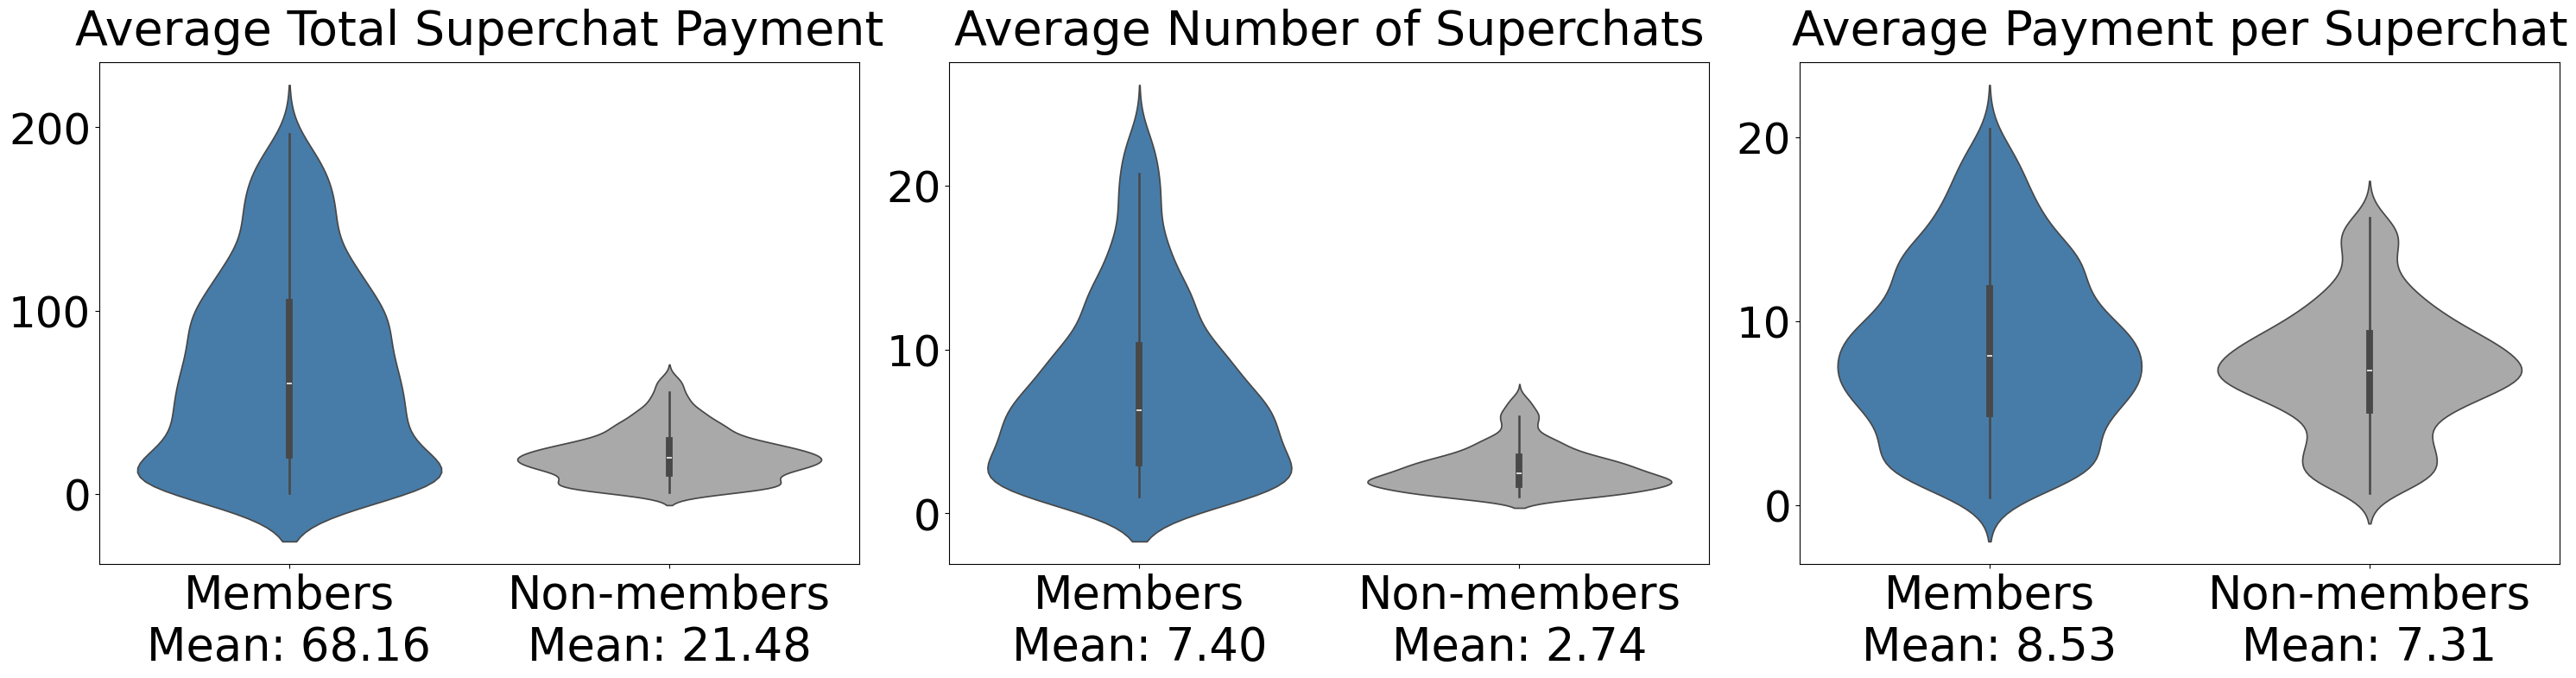

average payment of members vs. non-members
Wilcoxon signed-rank test: statistic=30955.0, p-value=1.5869122253513036e-127

average number of paid chats of members vs. non-members
Wilcoxon signed-rank test: statistic=23010.0, p-value=1.5128897581314913e-133

average payment per chat of members vs. non-members
Wilcoxon signed-rank test: statistic=137324.0, p-value=4.2403048474597713e-35


In [13]:
# Function to remove top 5% of values
def remove_top_5_percent(data):
    data = data.replace([np.inf, -np.inf], np.nan).dropna()
    upper_limit = np.percentile(data, 95)
    return [x for x in data if x <= upper_limit]

### data import
vtuber_stats = pd.read_csv('data/vtuber_stats.tsv', sep='\t')
data_member_cleaned = remove_top_5_percent(vtuber_stats['avg_payment_per_member'])
data_non_member_cleaned = remove_top_5_percent(vtuber_stats['avg_payment_per_non_member'])
data_member_chat_cleaned = remove_top_5_percent(vtuber_stats['avg_payment_per_chat_by_members'])
data_non_member_chat_cleaned = remove_top_5_percent(vtuber_stats['avg_payment_per_chat_by_non_members'])
data_member_num_chats_cleaned = remove_top_5_percent(vtuber_stats['avg_num_paid_chats_per_member'])
data_non_member_num_chats_cleaned = remove_top_5_percent(vtuber_stats['avg_num_paid_chats_per_non_member'])

### Create plot
def add_grouped_stats_below_xticks(ax, data, x_positions):
    for pos, values in zip(x_positions, data):
        mean_val = np.mean(values)
        ax.text(pos, -0.12, f'Mean: {mean_val:.2f}', ha='center', va='top', fontsize=38,
                transform=ax.get_xaxis_transform(), bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

fig, axes = plt.subplots(1, 3, figsize=(30, 8))

### plot average total Superchat payment
sns.violinplot(data=[data_member_cleaned, data_non_member_cleaned], ax=axes[0], 
               palette=[sns.color_palette("Set1")[1], '#A9A9A9'])
axes[0].set_title("Average Total Superchat Payment", fontsize=40, pad=15)
axes[0].set_xticklabels(['Members', 'Non-members'], fontsize=38)
axes[0].tick_params(axis='y', labelsize=36)
add_grouped_stats_below_xticks(axes[0], [data_member_cleaned, data_non_member_cleaned], [0, 1])

### plot average number of Superchat
sns.violinplot(data=[data_member_num_chats_cleaned, data_non_member_num_chats_cleaned], ax=axes[1], 
               palette=[sns.color_palette("Set1")[1], '#A9A9A9'])
axes[1].set_title("Average Number of Superchats", fontsize=40, pad=15)
axes[1].set_xticklabels(['Members', 'Non-members'], fontsize=38)
axes[1].tick_params(axis='y', labelsize=36)
add_grouped_stats_below_xticks(axes[1], [data_member_num_chats_cleaned, data_non_member_num_chats_cleaned], [0, 1])

### plot average payment per Superchat
sns.violinplot(data=[data_member_chat_cleaned, data_non_member_chat_cleaned], ax=axes[2], 
               palette=[sns.color_palette("Set1")[1], '#A9A9A9'])
axes[2].set_title("Average Payment per Superchat", fontsize=40, pad=15)
axes[2].set_xticklabels(['Members', 'Non-members'], fontsize=38)
axes[2].tick_params(axis='y', labelsize=36)
add_grouped_stats_below_xticks(axes[2], [data_member_chat_cleaned, data_non_member_chat_cleaned], [0, 1])

fig.tight_layout()
plt.show()

### statistical test
df_cleaned = vtuber_stats[['avg_payment_per_member', 'avg_payment_per_non_member']].replace([np.inf, -np.inf], np.nan).dropna()
stat, p_value = wilcoxon(df_cleaned['avg_payment_per_member'], df_cleaned['avg_payment_per_non_member'], nan_policy='omit')
print('average payment of members vs. non-members')
print(f"Wilcoxon signed-rank test: statistic={stat}, p-value={p_value}")
print()

df_cleaned = vtuber_stats[['avg_num_paid_chats_per_member', 'avg_num_paid_chats_per_non_member']].replace([np.inf, -np.inf], np.nan).dropna()
stat, p_value = wilcoxon(df_cleaned['avg_num_paid_chats_per_member'], df_cleaned['avg_num_paid_chats_per_non_member'], nan_policy='omit')
print('average number of paid chats of members vs. non-members')
print(f"Wilcoxon signed-rank test: statistic={stat}, p-value={p_value}")
print()

df_cleaned = vtuber_stats[['avg_payment_per_chat_by_members', 'avg_payment_per_chat_by_non_members']].replace([np.inf, -np.inf], np.nan).dropna()
stat, p_value = wilcoxon(df_cleaned['avg_payment_per_chat_by_members'], df_cleaned['avg_payment_per_chat_by_non_members'], nan_policy='omit')
print('average payment per chat of members vs. non-members')
print(f"Wilcoxon signed-rank test: statistic={stat}, p-value={p_value}")

# Figure 16 -- VTuber Network Constructed through Shared Loyal Viewers

In [14]:
### data import
vtuber_stats = pd.read_csv('data/vtuber_stats.tsv', sep='\t')
all_vtubers = vtuber_stats['vtuber_name'].tolist()

vtubers_with_loyal_viewers = []
with open("data/loyal_users_per_vtuber.jsonl") as f:
    for line in f:
        data = json.loads(line)
        vtubers_with_loyal_viewers.append(data["vtuber_name"])
vtubers_without_loyal_viewers = list(set(all_vtubers).difference(set(vtubers_with_loyal_viewers)))
id_to_vtuber = {idx: vtuber for idx, vtuber in enumerate(vtubers_with_loyal_viewers)}
id_to_vtubers_without_loyal_viewers = {idx: streamer for idx, streamer in enumerate(vtubers_without_loyal_viewers, start=1573)}
id_to_vtuber.update(id_to_vtubers_without_loyal_viewers)
affiliations = [aff.lower() if pd.notna(aff) else aff for aff in vtuber_stats['affiliation']]
for i, aff in enumerate(affiliations):
    if isinstance(aff, str):
        if 'NIJISANJI'.lower() in aff:
            affiliations[i] = 'NIJISANJI'.lower()
        if 'hololive' in aff or 'HOLOSTARS'.lower() in aff:
            affiliations[i] = 'hololive'.lower()
    else:
        affiliations[i] = 'N/A'
vtuber_affiliation_dict = {vtuber : affiliation.strip() for vtuber, affiliation in zip (all_vtubers, affiliations)}
vtuber_id_to_aff = {idx : vtuber_affiliation_dict[id_to_vtuber[idx]] for idx in id_to_vtuber}

vtuber_similarity_matrix = np.load("data/vtuber_similarity_matrix.npy")

### create graph
similarity_threshold = 0.1
G = nx.Graph()
for i, streamer in enumerate(vtubers_with_loyal_viewers):
    G.add_node(i, label=' ')
for i in range(len(vtubers_with_loyal_viewers)):
    for j in range(i + 1, len(vtubers_with_loyal_viewers)):
        similarity = vtuber_similarity_matrix[i, j]
        if similarity >= similarity_threshold:
            G.add_edge(i, j, weight=similarity)
for i, streamer in enumerate(vtubers_without_loyal_viewers, start=1573):
    G.add_node(i, label=' ')
    
for node, affiliation in vtuber_id_to_aff.items():
    G.nodes[node]["affiliation"] = affiliation
G.nodes[275]['label'] = 'nijisanji'
G.nodes[1562]['label'] = 'hololive'
G.nodes[651]['label'] = '.live'
G.nodes[1325]['label'] = '774 inc.'
G.nodes[798]['label'] = 'prism project'
G.nodes[1523]['label'] = 're:act'
G.nodes[1254]['label'] = 'vee'
G.nodes[1566]['label'] = 'flavr'
G.nodes[1413]['label'] = 'wactor'
G.nodes[57]['label'] = 'aka virtual'
G.nodes[806]['label'] = 'phase-connect'
G.nodes[916]['label'] = 'pixela'

### visualize graph
sigma = Sigma(
    G,
    node_label="label",  
    name = 'VTuber Similarities Based on Loyal Viewers',
    node_color="affiliation",
    max_categorical_colors=22,
    edge_label=None,
    default_edge_color='rgba(0, 0, 0, 0)',
    background_color='white',
    node_border_color_from='node',
    default_node_label_size=30,
    default_edge_size=0,
    node_size=G.degree,
    show_all_labels=True,
)
sigma

Sigma(nx.Graph with 1,713 nodes and 2,711 edges)